# Analysis of hand drawn maps

This script is for analysing hand drawn maps of the Willunga sub-basin based on manual water table mapping exercise and survey.

Rasters are made in ArcGis using the hand drawn contour data and converting it to a raster using "Topo2Raster" tool

Script is run in the `conda activate geo_env` enviroment

## Import packages

In [1]:
from __future__ import division

#import affine
#import contextily
import fiona
import geopandas as gpd
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter
import os
import numpy as np
import pyproj
import pandas as pd

import rasterio 
from rasterio.crs import CRS
from rasterio.enums import Resampling
from rasterio.features import rasterize
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import from_bounds
from rasterio import shutil as rio_shutil
from rasterio.vrt import WarpedVRT
from rasterio import Affine

from requests import Request
from scipy.interpolate import interpn
from scipy.interpolate import griddata
from scipy import stats
import sys
import shapely
from shapely.geometry import Point
from shapely.geometry import mapping, Polygon
import string
from owslib.wcs import WebCoverageService



%matplotlib inline

In [2]:
figuredirectory = r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\figures'

## Define functions

#### Pull in the raster files - function

In [3]:
def get_raster(raster_fname):

    wt_rstr = rasterio.open(raster_fname)

    with rasterio.open(raster_fname) as grd:
        wt_ar = grd.read()[0,:,:]
        wt_meta = grd.profile   
        wt_bounds = grd.bounds
        wt_res = grd.res

    mask = np.zeros_like(wt_ar)
    nrows,ncols = np.shape(mask)

    return wt_rstr, wt_ar, wt_meta, wt_bounds, wt_res, mask, nrows, ncols

#### Change raster to utm and save in new folder - function

In [4]:
def reproject_raster(in_path, out_path, dst_crs):

    """
    """
    # reproject raster to project crs
    with rasterio.open(in_path) as src:
        src_crs = src.crs
        transform, width, height = rasterio.warp.calculate_default_transform(src_crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()

        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height})

        with rasterio.open(out_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                rasterio.warp.reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
    return(out_path)

#### Get the well indices for the raster at every well location 

In [5]:
def get_well_ixs(df_head_at_wells_from_rstr, ncols_utm, nrows_utm, wt_meta_utm, wells_df_2_gdf):
    
    ## Get the centroid locations for every pixel
    cols, rows = np.meshgrid(np.arange(ncols_utm), np.arange(nrows_utm))
    xs, ys = rasterio.transform.xy(wt_meta_utm['transform'], rows, cols)
    X_array = np.array(xs)
    Y_array = np.array(ys)
    
    ## Calculate the distance from each well to every cell in order to get the well indexes
    well_ixs = []

    for ix in df_head_at_wells_from_rstr.index:

        e_well = wells_df_2_gdf.loc[ix, "mga_easting"]
        n_well = wells_df_2_gdf.loc[ix, "mga_northing"]

        c = np.sqrt((Y_array - n_well)**2 + (X_array - e_well)**2)
        well_ixs.append(np.unravel_index(np.argmin(c, axis=None), c.shape))
    
    return well_ixs

#### Get the head results for the raster

In [6]:
def get_raster_head_per_well(well_ixs, wt_ar_utm): 
    
    raster_head_vals = []

    for ix in well_ixs:
        raster_head_vals.append(wt_ar_utm[ix[0], ix[1]])
        
    return raster_head_vals

## Projection and colour set ups

In [7]:
wgs84 = pyproj.CRS('epsg:4326')
utm   = pyproj.CRS('epsg:32754')
gda94 = pyproj.CRS('epsg:4283')
austalbers = pyproj.CRS('epsg:3577')

wt_cmap = "coolwarm"
dem_cmap = "terrain"

## Pull in the well data


In [8]:
outputdatapath = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\output_data'

# In this dataframe are the original data
wells_df_1 = pd.read_csv(os.path.join(outputdatapath, "well_summary_gdf_ss_a1.csv"))

# In this dataframe I have added three new measurements BUT I have also removed some rswl values
wells_df_2 = pd.read_csv(os.path.join(outputdatapath, "well_summary_gdf_ss_c.csv"))

wells_df_1.index = wells_df_1.DHNO
wells_df_2.index = wells_df_2.DHNO

# Drop some columns to make it more manageable
wells_df_2 = wells_df_2.drop(columns=['Unit_No', 'Unit_Number', 'dh_name', 'network',
       'Obs_No', 'drillhole_class', 'water_point_type_code', 
       'Orig_drilled_depth', 'Orig_drilled_date', 
       'max_drill_date', 'late_open_depth', 'late_open_date', 'late_permit_no',
       'cased_to', 'case_min_diam',  'latest_status',
       'latest_status_date', 
       'EC', 'salinity_date', 'pH', 'pH_date', 'yield', 'yield_date',
        'long_degrees',
       'long_minutes', 'long_seconds', 'lat_degrees', 'lat_minutes',
       'lat_seconds', 'hundred', 'plan', 'parcel', 'Title', 'map_250k', 'map_100k', 'map_50k',
       'map_10k', 'map_2_5k', 'map_1k', 'water_info', 'salinity',
       'water_chemistry', 'geophys_log', 'drill_log', 'lith_log', 'geometry',
       'Datetime'])

## Make wells into geodataframe

In [9]:
# I've been fiddling around with the way to get the geometry but keep 
# getting Shapely error, not sure how to resolve but it doesn't seem to be a problem for now

geometry = []

for ix in wells_df_2.index:
    x = wells_df_2.loc[ix, "decimal_long"]
    y = wells_df_2.loc[ix, "neg_decimal_lat"]
    geometry.append(Point(x,y))

wells_df_2['geometry'] = geometry
wells_df_2_gdf = gpd.GeoDataFrame(wells_df_2, geometry='geometry', crs= 'epsg:4283')

C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


## Pull in shape file of study area extent

In [10]:
study_extent_path = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\study_extent', 'study_extent.shp')
study_area_shp = gpd.read_file(study_extent_path)
# Change to utm
study_area_shp_utm = study_area_shp.to_crs(utm)

## Plot the study area and wells

Text(68.02985398054291, 0.5, 'Northing')

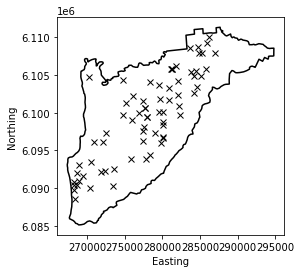

In [11]:
fig, (ax1) = plt.subplots(1, 1)
ax1.plot(wells_df_2_gdf['mga_easting'], wells_df_2_gdf['mga_northing'], "kx")
study_area_shp_utm.exterior.plot(ax=ax1, color="k", label="Study area")

plt.xlabel("Easting")
plt.ylabel("Northing")

## Check files in folder

In [12]:
fldr = r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters'

hand_output_raster_list = []
for file in os.listdir(fldr):
    if file.endswith(".tif"):
        hand_output_raster_list.append(file)
    else:
        pass
    
print(hand_output_raster_list)

['ref_001_raster.tif', 'ref_002_raster.tif', 'ref_003_raster.tif', 'ref_004_raster.tif', 'ref_005_raster.tif', 'ref_008_raster.tif', 'ref_009_raster.tif', 'ref_012b_raster.tif', 'ref_012_raster.tif', 'ref_014_raster.tif', 'ref_016_raster.tif', 'ref_017_raster.tif', 'ref_021_raster.tif', 'ref_024_raster.tif', 'ref_025_raster.tif', 'ref_026_raster.tif', 'ref_029_raster.tif', 'ref_030_raster.tif', 'ref_031_raster.tif', 'ref_032_raster.tif', 'ref_033_raster.tif', 'ref_034_raster.tif', 'ref_036_raster.tif']


## Set up my database

In [13]:
# Results for estimated head at every well location based on the rasterised results
df_head_at_wells_from_rstr = pd.DataFrame()
estimated_rasters = []
estimated_arrays = []

meta_rs = []
bounds_rs = []
res_rs = []

rstr_names = []
rstr_fnames = []

wt_crops_ars = []
wt_ar_crop_trfms = []
wt_ar_crop_metas = []

## LOOP TO PULL IN HAND DRAWN RASTER DATA

See https://rasterio.readthedocs.io/_/downloads/en/merge-crs/pdf/ for information about rasterio affine transformations, page 47 section 5.9.2 Coordinate Transformation:

`|x'|      |a b c| |x|`\
`|y'|  =   |d e f| |y|`\
`|1 |      |0 0 1| |1|`

a = width of a pixel
b = row rotation (typically zero)
c = x-coordinate of the upper-left corner of the upper-left pixel
d = column rotation (typically zero)
e = height of a pixel (typically negative)
f = y-coordinate of the of the upper-left corner of the upper-left pixel

This is also useful: https://www.perrygeo.com/python-affine-transforms.html

In [14]:
rstr_i = 0


for rstr_i in range(len(hand_output_raster_list)):

    # Put in loop but for now separate to test

    name_raster = hand_output_raster_list[rstr_i][:-11]
    raster_fname = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters', hand_output_raster_list[rstr_i])
    print(raster_fname)
    print(name_raster)

    # Realign and save as UTM raster if I have not already done this

    in_path = raster_fname
    out_path = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\utm_rasters', hand_output_raster_list[rstr_i])
    dst_crs = utm

    if os.path.isfile(out_path):
        pass
    else: 
        reproject_raster(in_path, out_path, dst_crs)

    # Pull in the utm raster file 

    wt_rstr_utm, wt_ar_utm, wt_meta_utm, wt_bounds_utm, wt_res_utm, mask, nrows_utm, ncols_utm = get_raster(out_path)

    
    # Crop the rasters based on shapefile
    
    with rasterio.open(out_path) as src:
        wt_ar_crop, wt_ar_crop_transform = rasterio.mask.mask(src, study_area_shp_utm.geometry, crop=False,
                                                     nodata=np.nan)
        wt_ar_crop_meta = src.meta

    # Add these to the databases

    estimated_rasters.append(wt_rstr_utm)
    estimated_arrays.append(wt_ar_utm)
    meta_rs.append(wt_meta_utm)
    bounds_rs.append(wt_bounds_utm)
    res_rs.append(wt_res_utm)
    rstr_names.append(name_raster)    
    rstr_fnames.append(raster_fname)
    
    wt_crops_ars.append(wt_ar_crop[0,:,:])
    wt_ar_crop_trfms.append(wt_ar_crop_transform)
    wt_ar_crop_metas.append(wt_ar_crop_meta)

C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_001_raster.tif
ref_001
C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_002_raster.tif
ref_002
C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_003_raster.tif
ref_003
C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_004_raster.tif
ref_004
C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_005_raster.tif
ref_005
C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_008_raster.tif
ref_008
C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_009_raster.tif
ref_009
C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_012b_raster.tif
ref_012b
C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_012_raster.tif
ref_012
C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_014_raster.tif
ref_014
C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\ref_016_raster.tif
ref_016
C:\Users

# Exploring the different rasters/arrays - with transforms

Because when I crop it, it removes the space around the shapefile which means that the arrays are different shapes IF crop=True, but I have set crop=False

In [15]:
print(type(wt_crops_ars[0]))
print(type(estimated_arrays[0]))
print("***")

print(np.shape(wt_crops_ars[0]))
print(np.shape(estimated_arrays[0]))
print("***")

print(wt_ar_crop_trfms[0])
print("***")

print(wt_ar_crop_metas[0])
print(meta_rs[0])
print("***")
print("But shouldn't the upper left pixel be different spot since it has been cropped off?")

print(wt_ar_crop_metas[0]['transform'])
print(wt_meta_utm['transform'])

# Info about rasterio transformation: https://rasterio.readthedocs.io/en/latest/quickstart.html

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
***
(267, 287)
(267, 287)
***
| 98.81, 0.00, 266930.50|
| 0.00,-98.81, 6111495.34|
| 0.00, 0.00, 1.00|
***
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028230607370965e+38, 'width': 287, 'height': 267, 'count': 1, 'crs': CRS.from_epsg(32754), 'transform': Affine(98.81347748669839, 0.0, 266930.5015377677,
       0.0, -98.81347748669839, 6111495.336834743)}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028230607370965e+38, 'width': 287, 'height': 267, 'count': 1, 'crs': CRS.from_epsg(32754), 'transform': Affine(98.81347748669839, 0.0, 266930.5015377677,
       0.0, -98.81347748669839, 6111495.336834743), 'tiled': False, 'interleave': 'band'}
***
But shouldn't the upper left pixel be different spot since it has been cropped off?
| 98.81, 0.00, 266930.50|
| 0.00,-98.81, 6111495.34|
| 0.00, 0.00, 1.00|
| 98.81, 0.00, 266930.50|
| 0.00,-98.81, 6111495.34|
| 0.00, 0.00, 1.00|


In [16]:
print(len(wt_crops_ars))

23


<AxesSubplot:>

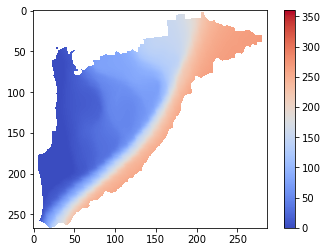

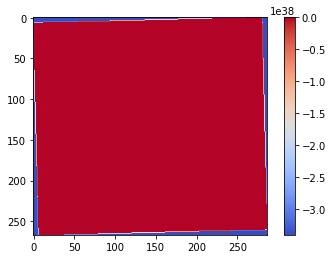

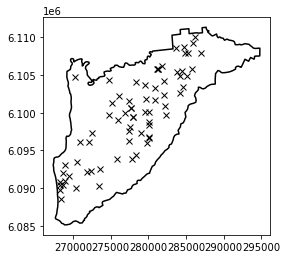

In [17]:
ix = 1

plt.figure()
#plt.subplot(,1,1)
img = plt.imshow(wt_crops_ars[ix], vmin=0, vmax=360, cmap=wt_cmap)
plt.colorbar(img)

plt.figure()
#plt.subplot(,1,1)
img = plt.imshow(estimated_arrays[ix], vmax=0, cmap=wt_cmap)
plt.colorbar(img)

fig, (ax1) = plt.subplots(1, 1)
ax1.plot(wells_df_2_gdf['mga_easting'], wells_df_2_gdf['mga_northing'], "kx")
study_area_shp_utm.exterior.plot(ax=ax1, color="k", label="Study area")


In [18]:
print(np.max(estimated_arrays[0]))
print(np.max(estimated_arrays[1]))
print(np.max(estimated_arrays[2]))
print(np.max(estimated_arrays[3]))
print(np.max(estimated_arrays[4]))

358.0
268.0
264.53348
270.0
270.0


for i in range(len(rstr_names)):
    fig,axes = plt.subplots(1,2, figsize=(15, 15))
    img = axes[0].imshow(estimated_arrays[i], vmin=0, vmax=360, cmap=wt_cmap)
    #plt.colorbar(img, ax=axes[0], fraction=0.046, pad=0.04)

    img = axes[1].imshow(wt_crops_ars[i], vmin=0, vmax=360, cmap=wt_cmap)
    plt.colorbar(img, ax=axes[1],fraction=0.046, pad=0.04)

### Add index & rswl to my results dataframe

In [19]:
df_head_at_wells_from_rstr["DHNO"] = wells_df_2.DHNO
df_head_at_wells_from_rstr.index = df_head_at_wells_from_rstr.DHNO
df_head_at_wells_from_rstr["rswl"] = wells_df_2["rswl"]

# Need to add head value where there is a letter

In [20]:
df_head_at_wells_from_rstr.head()

,DHNO,rswl
DHNO,,
26558,26558,4.09
26565,26565,4.33
26585,26585,18.22
27050,27050,5.54
27063,27063,15.9


In [21]:
wells_df_2.head(2)

,Unnamed: 0,DHNO,Aquifer,max_drill_depth,purpose,dtw,swl,rswl,water_level_date,TDS,mga_easting,mga_northing,mga_zone,decimal_long,decimal_lat,neg_decimal_lat,dropped,new_well_locations,geometry
DHNO,,,,,,,,,,,,,,,,,,,
26558,26558,26558,Te2,340.1,OBS,18.29,18.36,4.09,8/09/2021,43438.0,268941.81,6093083.52,54.0,138.459534,35.278757,-35.278757,N,N,POINT (138.45953 -35.27876)
26565,26565,26565,Te2,105.0,INVOBS,41.70,41.30,4.33,10/09/2021,2092.0,270906.82,6096136.56,54.0,138.481972,35.251705,-35.251705,N,N,POINT (138.48197 -35.25171)


In [22]:
alphabet = string.ascii_lowercase
list_letters = []

for i in range(9):
    list_letters.append(alphabet[i])
    
wells_letter_df = wells_df_2[wells_df_2["rswl"].isin(list_letters)]

wells_df_1["DHNO"] =  wells_df_1["DHNO"].astype(str)

wells_df_1.index = wells_df_1.DHNO

news = ['new1', 'new2', 'new3', 'new4']

for ix in wells_letter_df.index:
    if ix in news:
        df_head_at_wells_from_rstr.loc[ix, "rswl"] = np.nan
    else:
#        print("start")
 #       print(ix)
        df_head_at_wells_from_rstr.loc[ix, "rswl"] = wells_df_1.loc[ix, "rswl"]

#print(df_head_at_wells_from_rstr['rswl'])

In [23]:
df_head_at_wells_from_rstr

,DHNO,rswl
DHNO,,
26558,26558,4.09
26565,26565,4.33
26585,26585,18.22
27050,27050,5.54
27063,27063,15.9
...,...,...
200678,200678,128.99
new1,new1,NaN
new2,new2,NaN


In [24]:
wells_letter_df

,Unnamed: 0,DHNO,Aquifer,max_drill_depth,purpose,dtw,swl,rswl,water_level_date,TDS,mga_easting,mga_northing,mga_zone,decimal_long,decimal_lat,neg_decimal_lat,dropped,new_well_locations,geometry
DHNO,,,,,,,,,,,,,,,,,,,
27125,27125,27125,Qpa,3.9,OBS,2.08,1.71,a,8/09/2021,8327.0,268703.740,6091952.550,54.0,138.456600,35.288890,-35.288890,Y,N,POINT (138.45660 -35.28889)
39875,39875,39875,Qpam,82.3,OBS,74.33,74.11,b,10/09/2021,1285.0,273473.760,6090244.520,54.0,138.508536,35.305368,-35.305368,Y,N,POINT (138.50854 -35.30537)
42108,42108,42108,Te2,4.0,OBS,0.00,-0.06,i,15/09/2021,716.0,285247.330,6107931.760,54.0,138.642544,35.148614,-35.148614,Y,N,POINT (138.64254 -35.14861)
46232,46232,46232,Te2,233.0,INVOBS,67.88,66.33,h,14/09/2021,1242.0,282211.770,6100862.530,54.0,138.607380,35.211650,-35.211650,Y,N,POINT (138.60738 -35.21165)
180822,180822,180822,Qpa,38.5,MON,1.78,1.85,f,14/09/2021,3052.0,277727.790,6100638.500,54.0,138.558098,35.212684,-35.212684,Y,N,POINT (138.55810 -35.21268)
new1,0,new1,NaN,NaN,NaN,NaN,NaN,c,NaN,NaN,270522.908,6093429.894,NaN,138.477000,NaN,-35.276000,NaN,Y,POINT (138.47700 -35.27600)
new2,1,new2,NaN,NaN,NaN,NaN,NaN,g,NaN,NaN,282386.889,6099717.867,NaN,138.609000,NaN,-35.222000,NaN,Y,POINT (138.60900 -35.22200)
new3,2,new3,NaN,NaN,NaN,NaN,NaN,d,NaN,NaN,272184.180,6096136.190,NaN,138.496000,NaN,-35.252000,NaN,Y,POINT (138.49600 -35.25200)
new4,3,new4,NaN,NaN,NaN,NaN,NaN,e,NaN,NaN,270326.409,6104747.739,NaN,138.478000,NaN,-35.174000,NaN,Y,POINT (138.47800 -35.17400)


In [25]:
# Can delete later:  testing

#def get_well_ixs(df_head_at_wells_from_rstr, ncols_utm, nrows_utm, wt_meta_utm, wells_df_2_gdf):

## Get the centroid locations for every pixel
cols, rows = np.meshgrid(np.arange(ncols_utm), np.arange(nrows_utm))
xs, ys = rasterio.transform.xy(wt_meta_utm['transform'], rows, cols)
X_array = np.array(xs)
Y_array = np.array(ys)

## Calculate the distance from each well to every cell in order to get the well indexes
well_ixs = []

rswl_wells = []
e_wells = []
n_wells = []
c_vals = []
for ix in df_head_at_wells_from_rstr.index:

    e_well = wells_df_2_gdf.loc[ix, "mga_easting"]
    e_wells.append(e_well)
    n_well = wells_df_2_gdf.loc[ix, "mga_northing"]
    n_wells.append(n_well)
    rswl_wells.append(wells_df_2_gdf.loc[ix, "rswl"])

    c = np.sqrt((Y_array - n_well)**2 + (X_array - e_well)**2)
    c_vals.append(c)
    well_ixs.append(np.unravel_index(np.argmin(c, axis=None), c.shape))    

## Create well indexes for all wells without the letters 

In [92]:
df_head_at_wells_from_rstr.index

Index(['26558', '26565', '26585', '27050', '27063', '27107', '27112', '27113',
       '27117', '27118', '27119', '27121', '27125', '39875', '39932', '40002',
       '40495', '40740', '40794', '42029', '42104', '42108', '42117', '42173',
       '42190', '42279', '43439', '43470', '43490', '44644', '45105', '45276',
       '45418', '45475', '46069', '46129', '46196', '46212', '46229', '46232',
       '46299', '46552', '46725', '46726', '46734', '46736', '131933',
       '142342', '156132', '166221', '166767', '166769', '177637', '179079',
       '179080', '180822', '180838', '182233', '186362', '195701', '196280',
       '196571', '196608', '196609', '200676', '200677', '200678', 'new1',
       'new2', 'new3', 'new4'],
      dtype='object', name='DHNO')

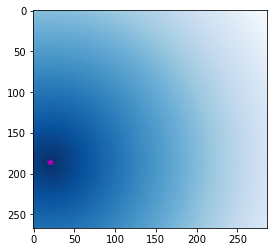

In [26]:
# Can delete: testing
len(c_vals)
len(wells_df_2_gdf)

plt.imshow(c_vals[0], cmap="Blues_r")

plt.plot(well_ixs[0][1], well_ixs[0][0], "m*")

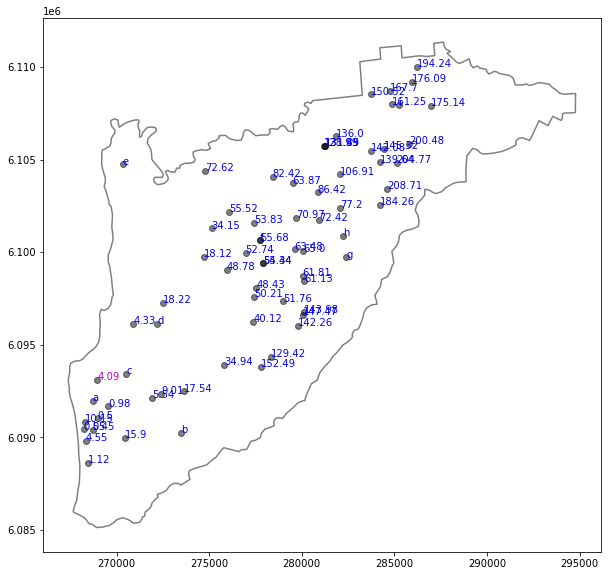

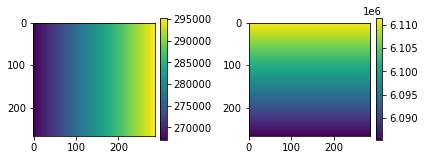

In [27]:
# Can delete: testing
# Checking it looks right

plt.figure(figsize=(10,10))
plt.plot(e_wells, n_wells, "ko", alpha=0.5)

for i in range(len(rswl_wells)):
    if i == 0:
        plt.text(e_wells[i], n_wells[i], "%s"%rswl_wells[i], c="m")
        
    else:
        plt.text(e_wells[i], n_wells[i], "%s"%rswl_wells[i], c="b")
    
ax1=plt.gca()
study_area_shp_utm.exterior.plot(ax=ax1, color="0.5", label="Study area")

plt.figure()
plt.subplot(1,2,1)
plt.imshow(xs)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.imshow(ys)
plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()

## Get the raster indices for the well locations

In [28]:
well_ixs = get_well_ixs(df_head_at_wells_from_rstr, ncols_utm, nrows_utm, wt_meta_utm, wells_df_2_gdf)
df_head_at_wells_from_rstr["well_ix"] = well_ixs
df_head_at_wells_from_rstr.head()

,DHNO,rswl,well_ix
DHNO,,,
26558,26558,4.09,"(186, 20)"
26565,26565,4.33,"(155, 40)"
26585,26585,18.22,"(144, 56)"
27050,27050,5.54,"(195, 50)"
27063,27063,15.9,"(217, 35)"


### Find the indexes that are letters

Put the true value for those that are known and replace those that are unknown with "Unknown"

In [114]:
df_head_at_wells_from_rstr_noletters = df_head_at_wells_from_rstr.copy()

for ix in wells_letter_df.index:
    df_head_at_wells_from_rstr_noletters = df_head_at_wells_from_rstr_noletters.drop(ix, axis=0)

In [118]:
print(len(df_head_at_wells_from_rstr_noletters))
print(len(df_head_at_wells_from_rstr))

62
71


## Get the head value from estimated rasters at each well location

In [30]:
for rstr_i in range(len(estimated_arrays)):
    
    raster_head_vals = get_raster_head_per_well(well_ixs, estimated_arrays[rstr_i])
    
    df_head_at_wells_from_rstr[rstr_names[rstr_i]] = raster_head_vals

In [31]:
df_head_at_wells_from_rstr.head()

,DHNO,rswl,well_ix,ref_001,ref_002,ref_003,ref_004,ref_005,ref_008,ref_009,...,ref_024,ref_025,ref_026,ref_029,ref_030,ref_031,ref_032,ref_033,ref_034,ref_036
DHNO,,,,,,,,,,,,,,,,,,,,,
26558,26558,4.09,"(186, 20)",-20.203262,-18.057812,-7.563098,2.955072,-9.637142,-1.262213,8.995111,...,-5.263478,-16.259899,1.112820,7.571603,10.148191,9.396303,-9.671530,4.646134,1.646033,-3.302031
26565,26565,4.33,"(155, 40)",1.742489,0.965118,4.902679,5.247573,-0.501065,5.967878,8.872720,...,6.314466,2.270485,7.920587,8.944342,9.866714,8.544065,5.303022,3.035818,6.485984,2.730164
26585,26585,18.22,"(144, 56)",14.311897,15.319687,17.065609,13.750219,15.092476,10.868571,10.327415,...,15.383167,14.800434,13.020567,16.676876,11.715546,10.691982,15.104589,18.527225,13.312990,15.187326
27050,27050,5.54,"(195, 50)",6.538256,2.622898,9.101677,8.543658,8.600751,5.021411,9.544954,...,9.427304,-1.686317,11.836983,8.609028,9.500857,9.704159,8.577205,5.394264,8.095343,8.371509
27063,27063,15.9,"(217, 35)",10.516420,12.784949,11.679647,12.474450,13.786293,13.844901,11.932571,...,7.214375,21.974171,16.659534,13.306984,10.436093,9.768251,11.934229,11.541338,12.745776,11.766327


## Plot correlation between measured rswl and estimated rswl from raster

ref_001


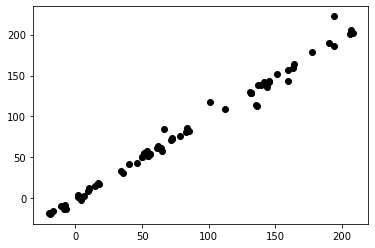

In [32]:
fig = plt.figure()
ax = plt.subplot(111)

rstr_i = 0
name_raster = rstr_names[rstr_i]
print(name_raster)

ax.plot(df_head_at_wells_from_rstr['ref_001'], df_head_at_wells_from_rstr['ref_002'], 'ko')

## Calculate cell by cell averages across all arrays

First, I need to combine all rasters into a single array, that will be the easiest way to do the statistics

In [33]:
wt_array_3d = np.array([estimated_arrays[0], estimated_arrays[1], estimated_arrays[2], estimated_arrays[3]]) 

wt_array_3d_crop = np.array([wt_crops_ars[0], wt_crops_ars[1], wt_crops_ars[2], wt_crops_ars[3]]) 

a = wt_array_3d[0,0][0]

wt_array_3d[wt_array_3d==a]=np.nan

wt_array_3d_crop[wt_array_3d_crop==a]=np.nan

In [34]:
np.shape(wt_array_3d)

max_array = np.amax(wt_array_3d, axis=0)
min_array = np.amin(wt_array_3d, axis=0)
range_array = max_array - min_array
std_array = np.std(wt_array_3d, axis=0)
mean_array = np.mean(wt_array_3d, axis=0)


max_array_crop = np.amax(wt_array_3d_crop, axis=0)
min_array_crop = np.amin(wt_array_3d_crop, axis=0)
range_array_crop = max_array - min_array
std_array_crop = np.std(wt_array_3d_crop, axis=0)
mean_array_crop = np.mean(wt_array_3d_crop, axis=0)


In [35]:
print(np.nanmax(wt_array_3d))
print(np.nanmax(wt_array_3d_crop))

358.0
333.73605


In [36]:
print(np.nanmax(mean_array_crop))

282.90863


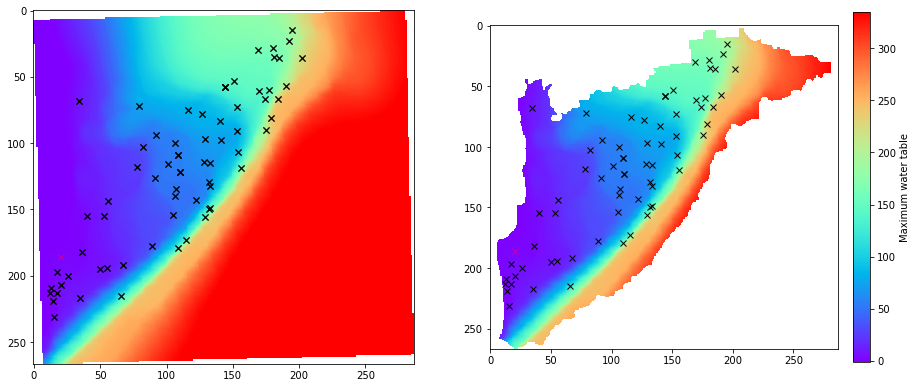

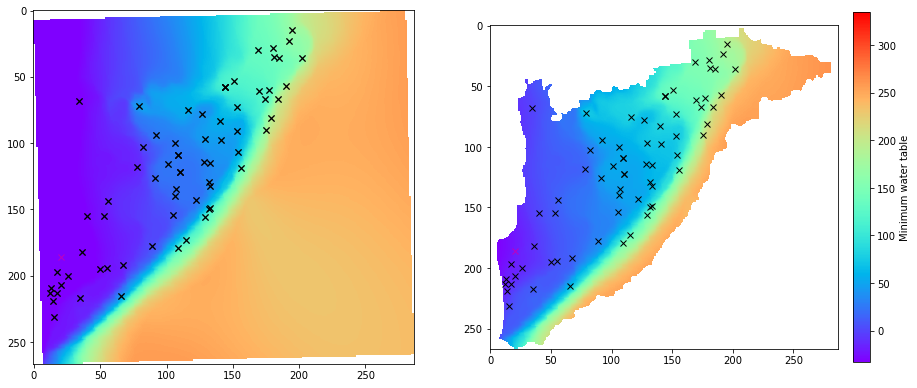

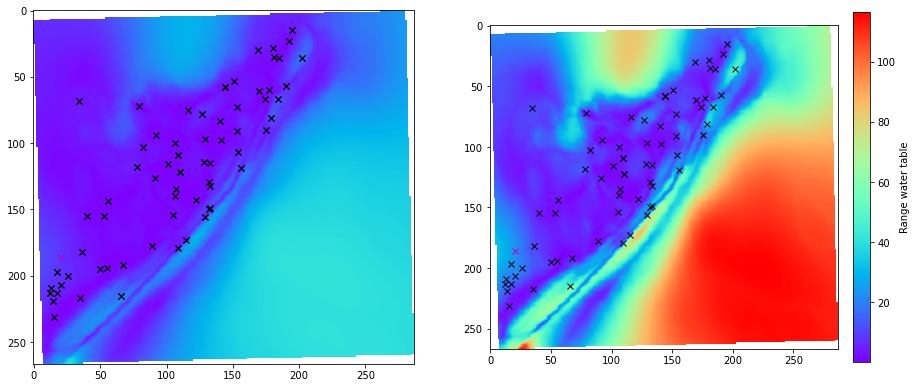

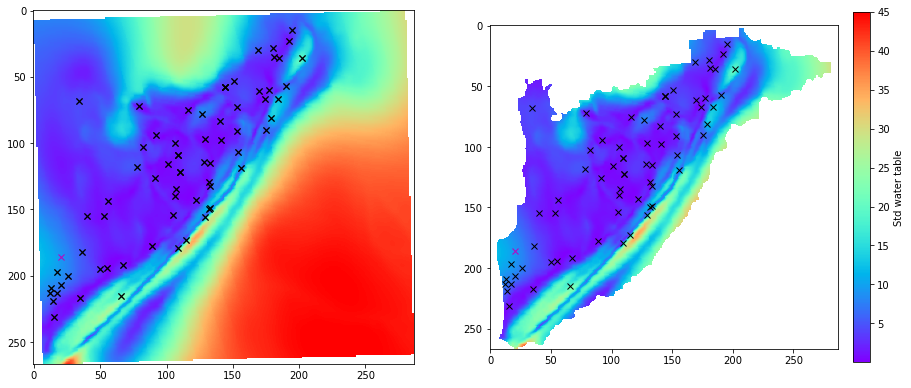

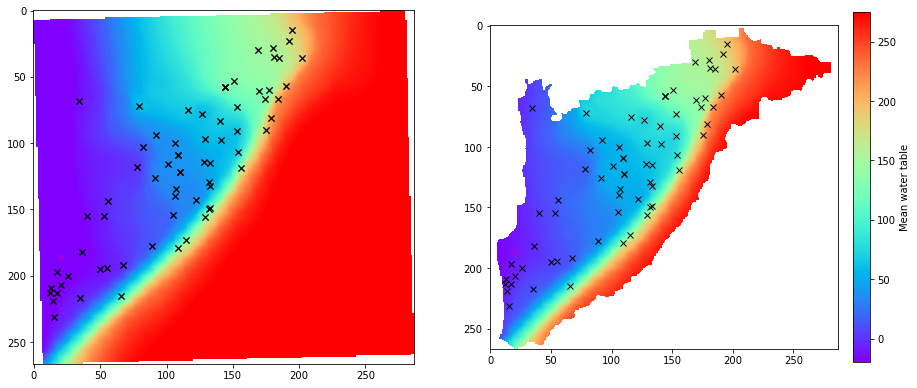

In [37]:
wt_cmap='rainbow'
# MAXIMUM

rstrs_for_plot = [max_array, max_array_crop]

fig,axes = plt.subplots(1,2, figsize=(15,15))

img = ax=axes[0].imshow(rstrs_for_plot[0], cmap=wt_cmap, vmin=0, vmax=335)

#plt.colorbar(img, ax=axes[0], label="Maximum water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")

img = ax=axes[1].imshow(rstrs_for_plot[1], cmap=wt_cmap , vmax=335)

plt.colorbar(img, ax=axes[1], label="Maximum water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "kx")
        
#-------------------------------------

# MINIMUM

rstrs_for_plot = [min_array, min_array_crop]

fig,axes = plt.subplots(1,2, figsize=(15,15))

img = ax=axes[0].imshow(rstrs_for_plot[0], cmap=wt_cmap, vmin=0, vmax=335)

#plt.colorbar(img, ax=axes[0], label="Maximum water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")

img = ax=axes[1].imshow(rstrs_for_plot[1], cmap=wt_cmap , vmax=335)

plt.colorbar(img, ax=axes[1], label="Minimum water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "kx")
        
        #-------------------------------------

# RANGE

rstrs_for_plot = [range_array, range_array_crop]

fig,axes = plt.subplots(1,2, figsize=(15,15))

img = ax=axes[0].imshow(rstrs_for_plot[0], cmap=wt_cmap, vmin=0, vmax=335)

#plt.colorbar(img, ax=axes[0], label="Maximum water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")

img = ax=axes[1].imshow(rstrs_for_plot[1], cmap=wt_cmap)# , vmax=335

plt.colorbar(img, ax=axes[1], label="Range water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "kx")
        
#-------------------------------------

        # STD

rstrs_for_plot = [std_array, std_array_crop]

fig,axes = plt.subplots(1,2, figsize=(15,15))

img = ax=axes[0].imshow(rstrs_for_plot[0], cmap=wt_cmap, vmin=0, vmax=45)

#plt.colorbar(img, ax=axes[0], label="Maximum water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")

img = ax=axes[1].imshow(rstrs_for_plot[1], cmap=wt_cmap , vmax=45)

plt.colorbar(img, ax=axes[1], label="Std water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "kx")
        
        #-------------------------------------

        # MEAN

rstrs_for_plot = [mean_array, mean_array_crop]

fig,axes = plt.subplots(1,2, figsize=(15,15))

img = ax=axes[0].imshow(rstrs_for_plot[0], cmap=wt_cmap, vmin=0, vmax=275)

#plt.colorbar(img, ax=axes[0], label="Maximum water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")
        axes[0].plot(well_ixs[i][1],well_ixs[i][0], "kx")

img = ax=axes[1].imshow(rstrs_for_plot[1], cmap=wt_cmap , vmax=275)

plt.colorbar(img, ax=axes[1], label="Mean water table",fraction=0.046, pad=0.04)

for i in range(len(well_ixs)):
    if i == 0:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "mx")
    else:
        axes[1].plot(well_ixs[i][1],well_ixs[i][0], "kx")

## Plots for the poster

Note that I can't get the array, wells and the colourbar all on one plot! So I'm going to have to make two and just amend the figure afterwards

### Write the arrays as rasters so I can plot them with the correct axis (then read them back in)

### First: the mean raster

In [38]:
mean_fname = os.path.join(r"C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\summary_rasters", 
                         "mean_wt.tif")

if os.path.exists(mean_fname):
    pass
else:
    new_dataset = rasterio.open(
        mean_fname,
        'w',                                 # Writing the file (making a new raster)
        driver='GTiff',
        height=wt_ar_crop_metas[0]['height'],
        width=wt_ar_crop_metas[0]['width'],
        count=1,                                            # A count of the dataset bands
        dtype=wt_ar_crop_metas[0]['dtype'],                           # Optional
        crs=wt_ar_crop_metas[0]['crs'],                                 # Optional  
        transform=wt_ar_crop_metas[0]['transform'])                    # Optional


    new_dataset.write(mean_array_crop, 1)
    new_dataset.close()

with rasterio.open(mean_fname) as grd:
    mean_ar = grd.read()[0,:,:]
    mean_meta = grd.profile   
    
mean_rstr = rasterio.open(mean_fname)

In [39]:
figuredirectory

'C:\\Users\\mar886\\WaterTableProject\\Willunga\\hand_output_rasters\\figures'

In [40]:
survey_levels = [0,10,20,30,40,50,60,70,80,90,100,125,150,175,200,225]

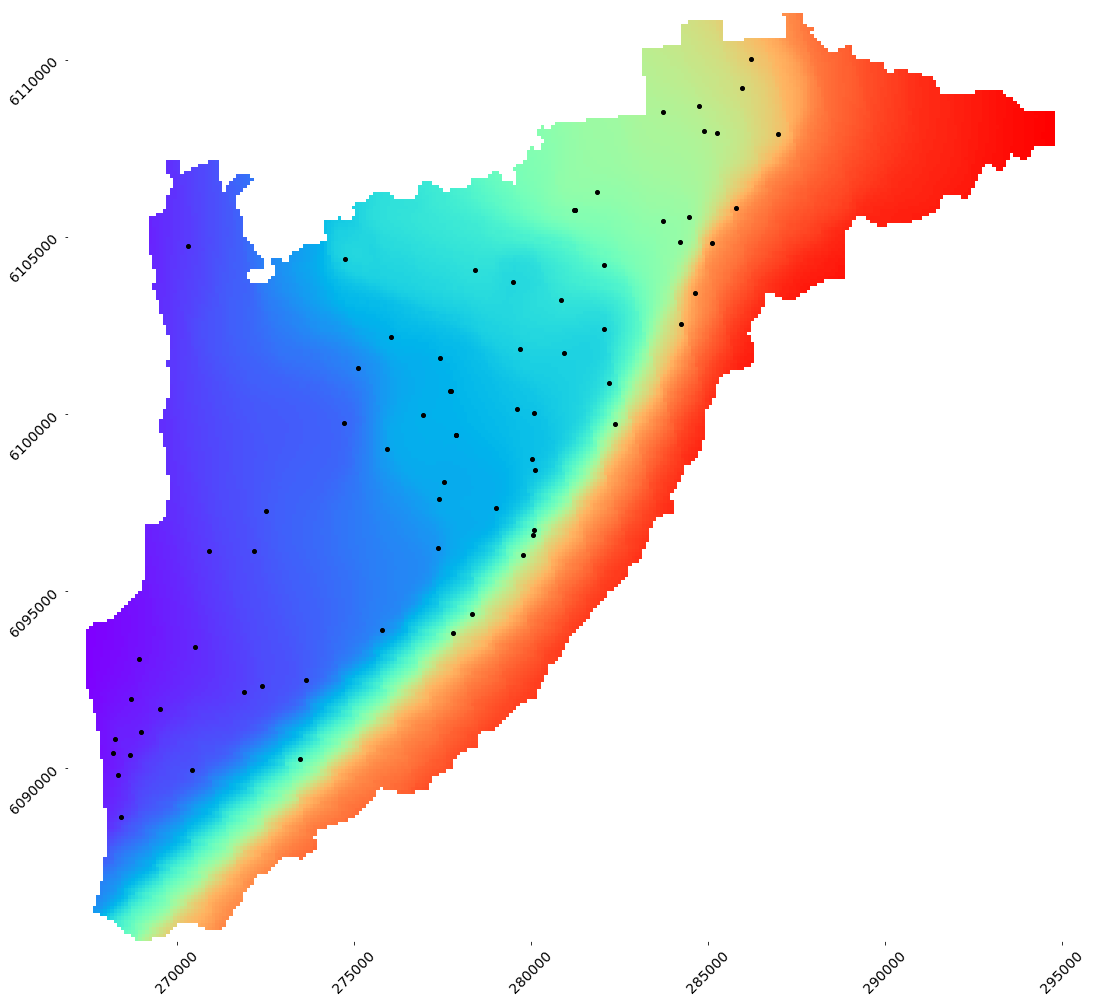

In [41]:
#-------------------------------------
plt.figure(figsize=(18,20), frameon=False)
ax1=plt.subplot(111)

image1 = show(mean_rstr, ax=ax1, cmap=wt_cmap)
ax1.plot(wells_df_2_gdf['mga_easting'], wells_df_2_gdf['mga_northing'], "ko", markersize=4)

ax1.ticklabel_format(style="plain")
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14, rotation=45)

ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
#fig.colorbar(image_hidden, ax=ax1)

#plt.xlabel("Easting", fontsize=14)
#plt.ylabel("Northing", fontsize=14)

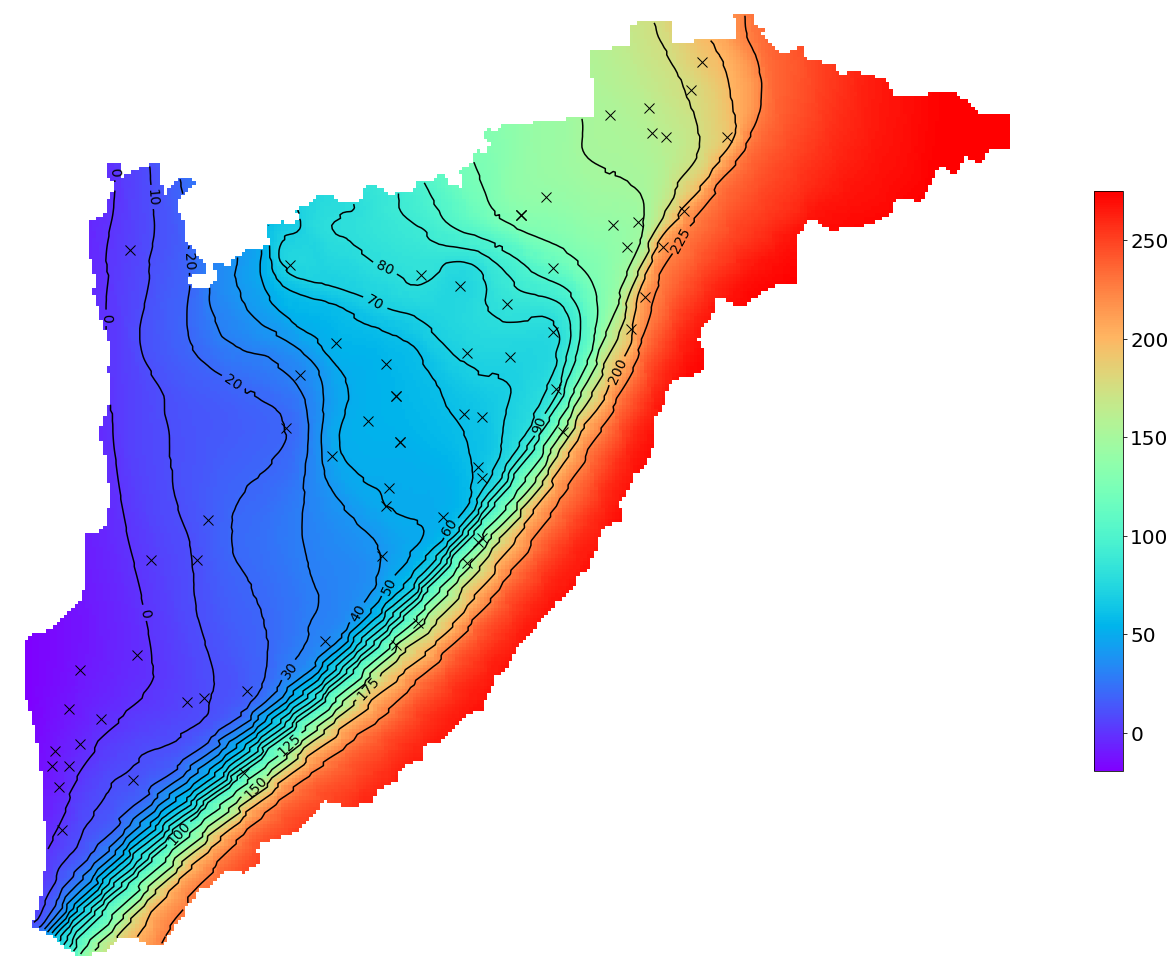

In [42]:
plt.figure(figsize=(20,20))
ax2=plt.subplot(111, frameon=False)

image_hidden = ax2.imshow(mean_array_crop, cmap=wt_cmap , vmax=275)

cb = plt.colorbar(image_hidden, fraction=0.026, pad=0.06)
for t in cb.ax.get_yticklabels():
     t.set_fontsize(20)
cs = plt.contour(mean_array_crop, levels=survey_levels, colors="k") #colors="k", 
plt.clabel(cs, inline=1, fontsize=14, fmt='%1i', colors="k")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

for i in range(len(well_ixs)):
    ax2.plot(well_ixs[i][1],well_ixs[i][0], "kx", markersize=10, label='_nolegend_')

ax2.plot(well_ixs[i][1],well_ixs[i][0], "kx", alpha=0.1, markersize=10, label="Hydraulic head measurement")    
#plt.legend(frameon=False, fontsize=18, loc=4)

plt.savefig(os.path.join(figuredirectory, "mean"), dpi=300)

### Second: the standard deviation raster

In [43]:
std_fname = os.path.join(r"C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\summary_rasters", 
                         "std_wt.tif")

if os.path.exists(std_fname):
    pass
else:
    new_dataset = rasterio.open(
        std_fname,
        'w',                                 # Writing the file (making a new raster)
        driver='GTiff',
        height=wt_ar_crop_metas[0]['height'],
        width=wt_ar_crop_metas[0]['width'],
        count=1,                                            # A count of the dataset bands
        dtype=wt_ar_crop_metas[0]['dtype'],                           # Optional
        crs=wt_ar_crop_metas[0]['crs'],                                 # Optional  
        transform=wt_ar_crop_metas[0]['transform'])                    # Optional


    new_dataset.write(std_array_crop, 1)
    new_dataset.close()
    
with rasterio.open(std_fname) as grd:
    std_ar = grd.read()[0,:,:]
    std_meta = grd.profile   
    
std_rstr = rasterio.open(std_fname)

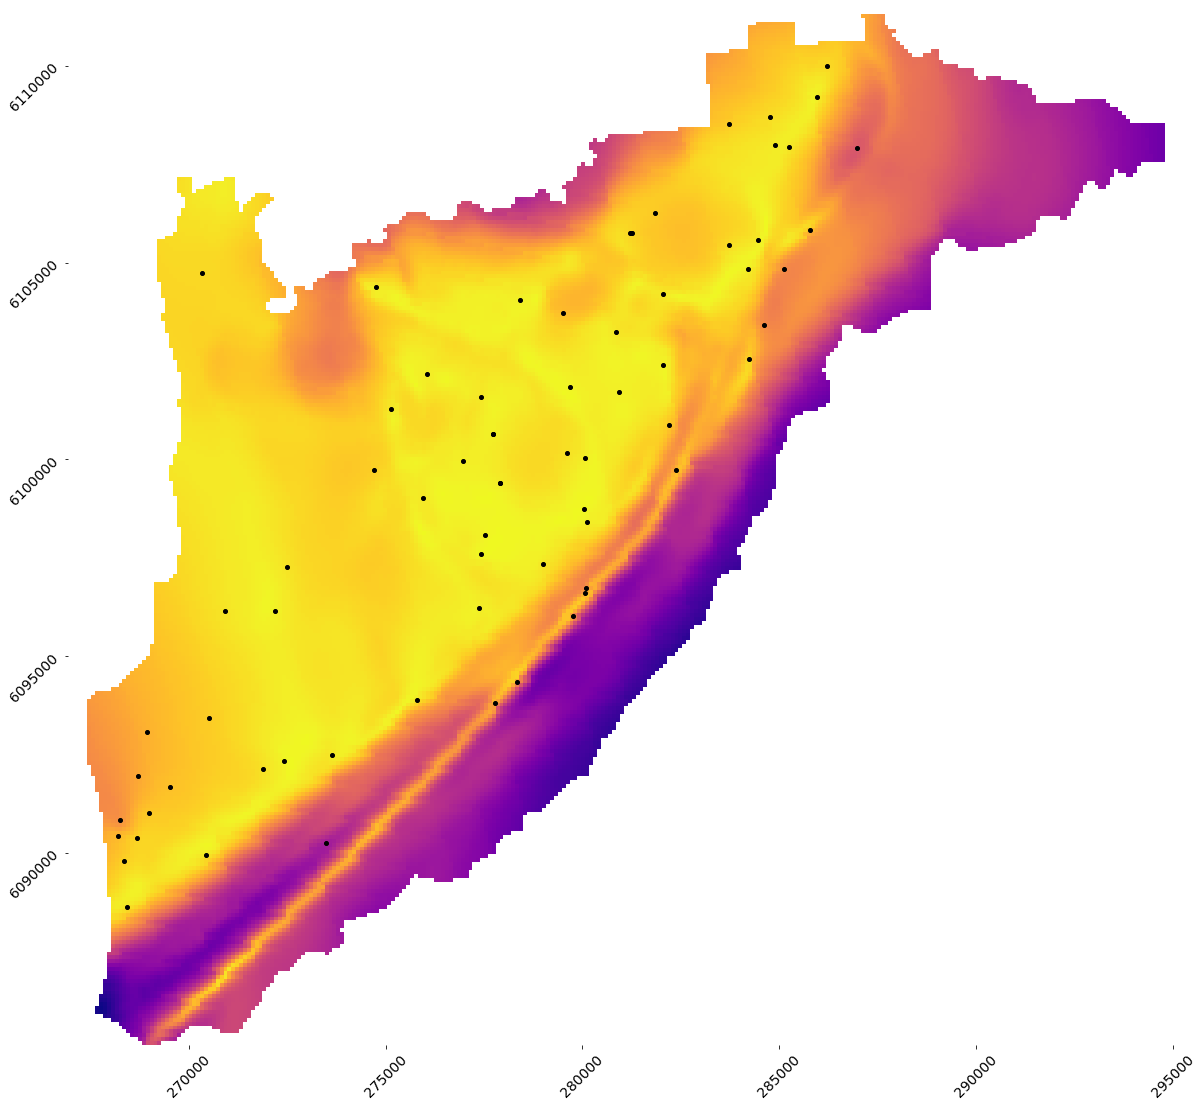

In [44]:
#-------------------------------------
plt.figure(figsize=(20,20))
ax1=plt.subplot(111, frameon=False)

image1 = show(std_rstr, ax=ax1, cmap='plasma_r')

ax1.plot(wells_df_2_gdf['mga_easting'], wells_df_2_gdf['mga_northing'], "ko", markersize=4)

ax1.ticklabel_format(style="plain")
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14, rotation=45)

ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')

#fig.colorbar(image_hidden, ax=ax1)

#plt.xlabel("Easting", fontsize=14)

#plt.ylabel("Northing", fontsize=14)

In [45]:
std_levels = [0,5,10,15,20,25,30,35,40,45]

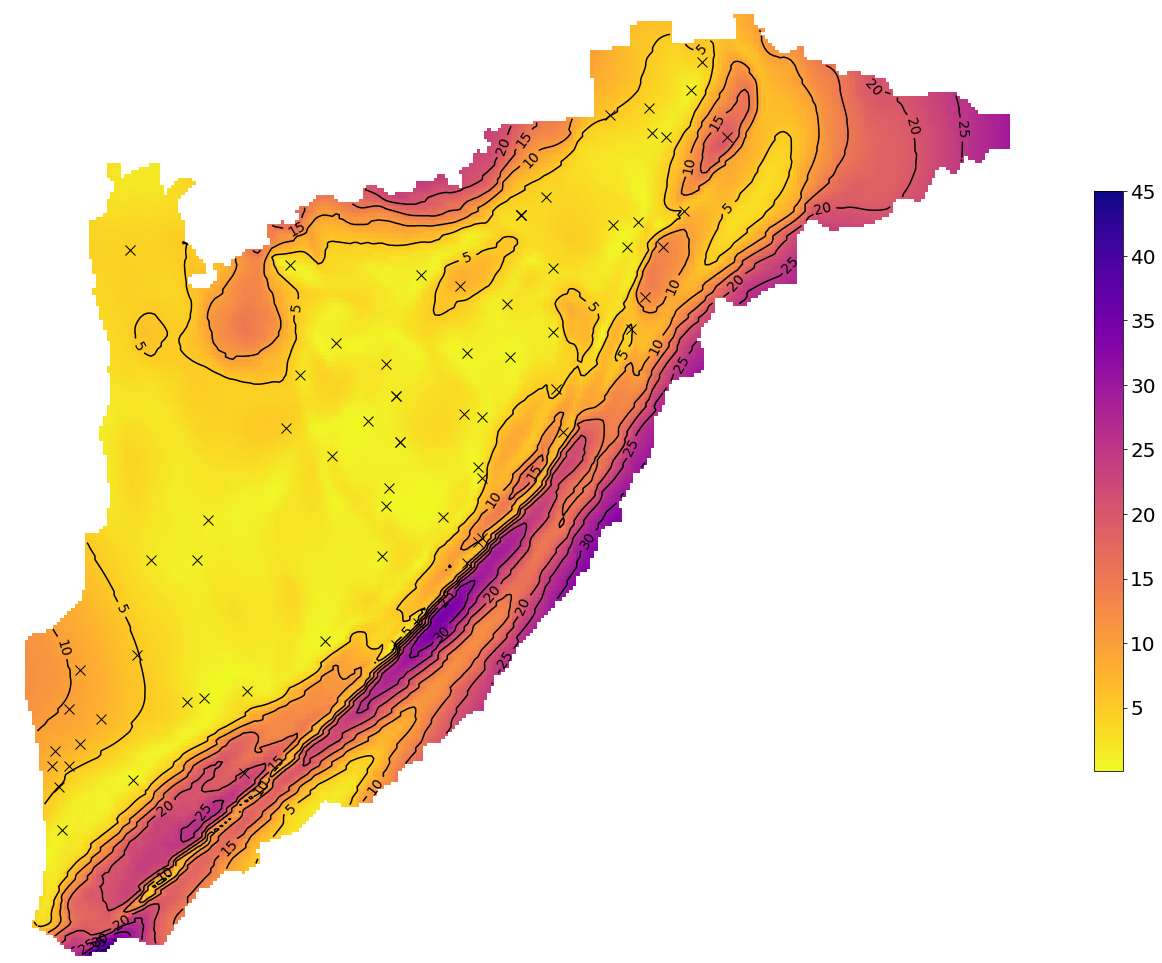

In [46]:
plt.figure(figsize=(20,20))

ax2=plt.subplot(111, frameon=False)

image_hidden = ax2.imshow(std_array_crop, cmap='plasma_r' , vmax=45)
cb = plt.colorbar(image_hidden, fraction=0.026, pad=0.06)

for t in cb.ax.get_yticklabels():
     t.set_fontsize(20)
        
cs = plt.contour(std_array_crop, colors="k", levels=std_levels) #colors="k", 
plt.clabel(cs, inline=1, fontsize=14, fmt='%1i', colors="k")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

for i in range(len(well_ixs)):
    ax2.plot(well_ixs[i][1],well_ixs[i][0], "kx", markersize=10, label='_nolegend_')

ax2.plot(well_ixs[i][1],well_ixs[i][0], "kx", alpha=0.1, markersize=10, label="Hydraulic head measurement")    
#plt.legend(frameon=False, fontsize=18, loc=4)

plt.savefig(os.path.join(figuredirectory, "std"), dpi=300)

# Pull in DEM and Warp the raster so it has same size, pixels etc as the utm water table rasters

What are the arrays that I have now that I need all in the same resolution?  

`wt_rstr_utm` --> one of the 'hand-drawn' water table rasters
`dem`    --> the dem


First, check they are all the same type.

In [47]:
dem_fname = "Hydro_Enforced_1_Second_DEM.tif"
wd = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\input_data\Elvis_dl_03122021'
dem_rstr = rasterio.open(os.path.join(wd, dem_fname))



In [48]:
print(type(dem_rstr))
print(type(wt_rstr_utm))

print('***')
print(dem_rstr.transform)
print(wt_rstr_utm.transform)

print('***')
print(dem_rstr.bounds)
print(wt_rstr_utm.bounds)


print('***')
print(dem_rstr.crs)
print(wt_rstr_utm.crs)

print('***')
print(dem_rstr.width)
print(wt_rstr_utm.width)

print('***')
print(dem_rstr.height)
print(wt_rstr_utm.height)

print('***')
print(dem_rstr.height)
print(wt_rstr_utm.height)

print('***')
print(dem_rstr.res)
print(wt_rstr_utm.res)

<class 'rasterio.io.DatasetReader'>
<class 'rasterio.io.DatasetReader'>
***
| 0.00, 0.00, 138.41|
| 0.00,-0.00,-35.08|
| 0.00, 0.00, 1.00|
| 98.81, 0.00, 266930.50|
| 0.00,-98.81, 6111495.34|
| 0.00, 0.00, 1.00|
***
BoundingBox(left=138.41236111134768, bottom=-35.36152777791627, right=138.74625000023127, top=-35.08013888901745)
BoundingBox(left=266930.5015377677, bottom=6085112.138345794, right=295289.9695764501, top=6111495.336834743)
***
EPSG:4203
EPSG:32754
***
1202
287
***
1013
267
***
1013
267
***
(0.0002777777777733735, 0.00027777777778758433)
(98.81347748669839, 98.81347748669839)


## Normalise DEM and WT to a consistent grid

From here: https://rasterio.readthedocs.io/en/latest/topics/virtual-warping.html

For the input files, you use the path to the tiffs

In [49]:
input_files = (
    r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\input_data\Elvis_dl_03122021\Hydro_Enforced_1_Second_DEM.tif',
    r'C:/Users/mar886/WaterTableProject/Willunga/hand_output_rasters/utm_rasters/ref_036_raster.tif'
)

In [50]:
# Destination CRS is UTM
dst_crs = wt_rstr_utm.crs 

# Boundary of raster
dst_bounds = wt_rstr_utm.bounds

# Output image dimensions
dst_height = wt_rstr_utm.height 
dst_width = wt_rstr_utm.width # Approximate to size using resolution of wt raster within bounds

# Output image transform
left, bottom, right, top = dst_bounds
xres = (right - left) / dst_width
yres = (top - bottom) / dst_height
dst_transform = Affine(xres, 0.0, left,
                              0.0, -yres, top)

vrt_options = {
    'resampling': Resampling.cubic,
    'crs': dst_crs,
    'transform': dst_transform,
    'height': dst_height,
    'width': dst_width,
}

## Doing the virtual warp  to each file

Save the names of the outfiles, to make it easy to see which have been created and where they were saved.

In [51]:
outfile_names = []
for path in input_files:

    with rasterio.open(path) as src:

        with WarpedVRT(src, **vrt_options) as vrt:

            # At this point 'vrt' is a full dataset with dimensions,
            # CRS, and spatial extent matching 'vrt_options'.

            # Read all data into memory.
            data = vrt.read()

            # Process the dataset in chunks.  Likely not very efficient.
            for _, window in vrt.block_windows():
                data = vrt.read(window=window)

            # Dump the aligned data into a new file.  A VRT representing
            # this transformation can also be produced by switching
            # to the VRT driver.
            directory, name = os.path.split(path)
            
            # Change the directory
            directory_outfiles = os.path.join("output_data", "utm_wt_ALIGNED")
            
            outfile = os.path.join(directory_outfiles, 'aligned-{}'.format(name))
            rio_shutil.copy(vrt, outfile, driver='GTiff')
            
            outfile_names.append(outfile)       

## Pull back in aligned UTM raster

In [52]:
outfile_names

['output_data\\utm_wt_ALIGNED\\aligned-Hydro_Enforced_1_Second_DEM.tif',
 'output_data\\utm_wt_ALIGNED\\aligned-ref_036_raster.tif']

In [53]:
dem_rstr_path_utm = outfile_names[0]

with rasterio.open(dem_rstr_path_utm) as grd:
    dem_ar = grd.read()[0,:,:]
    dem_meta = grd.profile   
    dem_bounds = grd.bounds
    dem_res = grd.res
    
mask = np.zeros_like(dem_ar)
nrows,ncols = np.shape(mask)

In [54]:
print(type(dem_rstr))

print("DEM raster crs is: %s" % dem_rstr.crs)
print("DEM raster shape: %s" % (dem_rstr.shape,))
print("DEM raster type: %s" % (type(dem_rstr)))

print("DEM raster mode is: %s" %dem_rstr.mode)
print("Is the DEM raster closed?: %s" %dem_rstr.closed)

print(dem_meta)

<class 'rasterio.io.DatasetReader'>
DEM raster crs is: EPSG:4203
DEM raster shape: (1013, 1202)
DEM raster type: <class 'rasterio.io.DatasetReader'>
DEM raster mode is: r
Is the DEM raster closed?: False
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 287, 'height': 267, 'count': 1, 'crs': CRS.from_epsg(32754), 'transform': Affine(98.81347748669832, 0.0, 266930.5015377677,
       0.0, -98.81347748669988, 6111495.336834743), 'tiled': False, 'interleave': 'band'}


In [55]:
dem_rstr = rasterio.open(dem_rstr_path_utm)


In [56]:
print(np.min(dem_ar))
print(np.max(dem_ar))


-3.4028235e+38
433.11816


## Crop the DEM raster based on shapefile

In [57]:
dem_rstr_path_utm

with rasterio.open(dem_rstr_path_utm) as src:
    dem_ar_crop, dem_ar_crop_transform = rasterio.mask.mask(src, study_area_shp_utm.geometry, crop=False,
                                                 nodata=np.nan)
    dem_ar_crop_meta = src.meta

### Plot the DEM

C:\Users\mar886\AppData\Local\Temp/ipykernel_17628/1652527271.py:21: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(image_hidden)


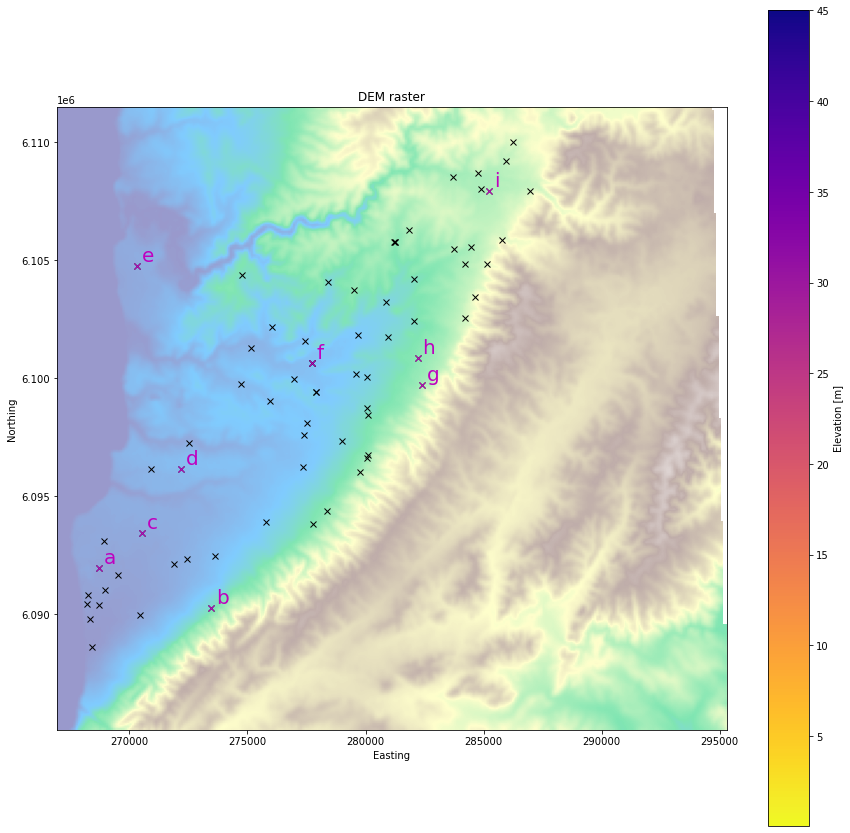

In [58]:
fig, (ax1) = plt.subplots(1, 1,  figsize=(15, 15))

plt.plot(e_wells, n_wells, "kx")
plt.plot(wells_letter_df['mga_easting'], wells_letter_df['mga_northing'], "mx")

offset_am = 200

for ix in wells_letter_df.index:
    plt.text(wells_letter_df.loc[ix, 'mga_easting']+offset_am, 
             wells_letter_df.loc[ix, 'mga_northing']+offset_am, 
             wells_letter_df.loc[ix, 'rswl'], c="m", fontsize=20)

imge_hidden = ax1.imshow(dem_ar, cmap=dem_cmap, vmin=0, vmax=500)

show(dem_rstr, ax=ax1, cmap=dem_cmap, vmin=0, vmax=500, alpha=0.5)
ax1.set_xlabel("Easting")
ax1.set_ylabel("Northing")

ax1.set_title('DEM raster')

cbar = plt.colorbar(image_hidden)
cbar.set_label('Elevation [m]')

#x1.plot(wells_df_2_gdf['mga_easting'], wells_df_2_gdf['mga_northing'], "ko", markersize=4)


## Plot cropped DEM

In [59]:
df_head_at_wells_from_rstr.tail()

,DHNO,rswl,well_ix,ref_001,ref_002,ref_003,ref_004,ref_005,ref_008,ref_009,...,ref_024,ref_025,ref_026,ref_029,ref_030,ref_031,ref_032,ref_033,ref_034,ref_036
DHNO,,,,,,,,,,,,,,,,,,,,,
200678,200678,128.99,"(58, 144)",132.011780,128.824036,136.926422,129.308899,135.046509,127.574760,135.647949,...,125.748276,108.799210,128.413345,128.026855,130.100235,132.226929,132.508743,112.554146,133.473969,127.607063
new1,new1,NaN,"(182, 36)",-7.708371,-8.037018,2.343328,2.459142,-0.545681,0.018456,8.502505,...,3.837847,-13.064213,8.277631,6.768766,9.825121,8.729925,-0.178159,3.048712,3.173881,2.611526
new2,new2,NaN,"(119, 156)",159.834564,143.357864,145.505524,155.230057,89.188828,153.021423,144.705414,...,118.454544,150.733521,87.072304,180.091339,86.113464,87.635262,94.990967,92.177689,107.425339,106.873566
new3,new3,NaN,"(155, 53)",9.999249,11.607593,12.187277,9.432354,10.877201,10.535300,10.058204,...,11.857807,11.117329,11.414048,12.432697,10.618283,10.055367,12.041704,12.226385,10.606509,10.835374
new4,new4,NaN,"(68, 34)",4.326117,-1.677065,7.789410,9.318331,0.805374,3.097975,44.012310,...,-2.589106,9.135742,3.086692,40.730713,38.841431,30.087482,19.697723,2.666463,2.990274,4.443453


In [70]:
df_head_at_wells_from_rstr.loc[ix, 'well_ix']


(68, 34)

In [71]:
for ix in wells_letter_df.index:
    x = df_head_at_wells_from_rstr.loc[ix, 'well_ix'][1]
    y = df_head_at_wells_from_rstr.loc[ix, 'well_ix'][0]
    ltr = wells_letter_df.loc[ix, 'rswl']
    print(x, y, ltr)

17 197 a
66 215 b
185 36 i
154 107 h
109 109 f
36 182 c
156 119 g
53 155 d
34 68 e


In [60]:
wells_letter_ixs = []
for ix in wells_letter_df.index:
    wells_letter_ixs.append(df_head_at_wells_from_rstr.loc[ix, 'well_ix'])
print(wells_letter_ixs)

[(197, 17), (215, 66), (36, 185), (107, 154), (109, 109), (182, 36), (119, 156), (155, 53), (68, 34)]


In [67]:
wells_letter_df

,Unnamed: 0,DHNO,Aquifer,max_drill_depth,purpose,dtw,swl,rswl,water_level_date,TDS,mga_easting,mga_northing,mga_zone,decimal_long,decimal_lat,neg_decimal_lat,dropped,new_well_locations,geometry
DHNO,,,,,,,,,,,,,,,,,,,
27125,27125,27125,Qpa,3.9,OBS,2.08,1.71,a,8/09/2021,8327.0,268703.740,6091952.550,54.0,138.456600,35.288890,-35.288890,Y,N,POINT (138.45660 -35.28889)
39875,39875,39875,Qpam,82.3,OBS,74.33,74.11,b,10/09/2021,1285.0,273473.760,6090244.520,54.0,138.508536,35.305368,-35.305368,Y,N,POINT (138.50854 -35.30537)
42108,42108,42108,Te2,4.0,OBS,0.00,-0.06,i,15/09/2021,716.0,285247.330,6107931.760,54.0,138.642544,35.148614,-35.148614,Y,N,POINT (138.64254 -35.14861)
46232,46232,46232,Te2,233.0,INVOBS,67.88,66.33,h,14/09/2021,1242.0,282211.770,6100862.530,54.0,138.607380,35.211650,-35.211650,Y,N,POINT (138.60738 -35.21165)
180822,180822,180822,Qpa,38.5,MON,1.78,1.85,f,14/09/2021,3052.0,277727.790,6100638.500,54.0,138.558098,35.212684,-35.212684,Y,N,POINT (138.55810 -35.21268)
new1,0,new1,NaN,NaN,NaN,NaN,NaN,c,NaN,NaN,270522.908,6093429.894,NaN,138.477000,NaN,-35.276000,NaN,Y,POINT (138.47700 -35.27600)
new2,1,new2,NaN,NaN,NaN,NaN,NaN,g,NaN,NaN,282386.889,6099717.867,NaN,138.609000,NaN,-35.222000,NaN,Y,POINT (138.60900 -35.22200)
new3,2,new3,NaN,NaN,NaN,NaN,NaN,d,NaN,NaN,272184.180,6096136.190,NaN,138.496000,NaN,-35.252000,NaN,Y,POINT (138.49600 -35.25200)
new4,3,new4,NaN,NaN,NaN,NaN,NaN,e,NaN,NaN,270326.409,6104747.739,NaN,138.478000,NaN,-35.174000,NaN,Y,POINT (138.47800 -35.17400)


In [91]:
figuredirectory

'C:\\Users\\mar886\\WaterTableProject\\Willunga\\hand_output_rasters\\figures'

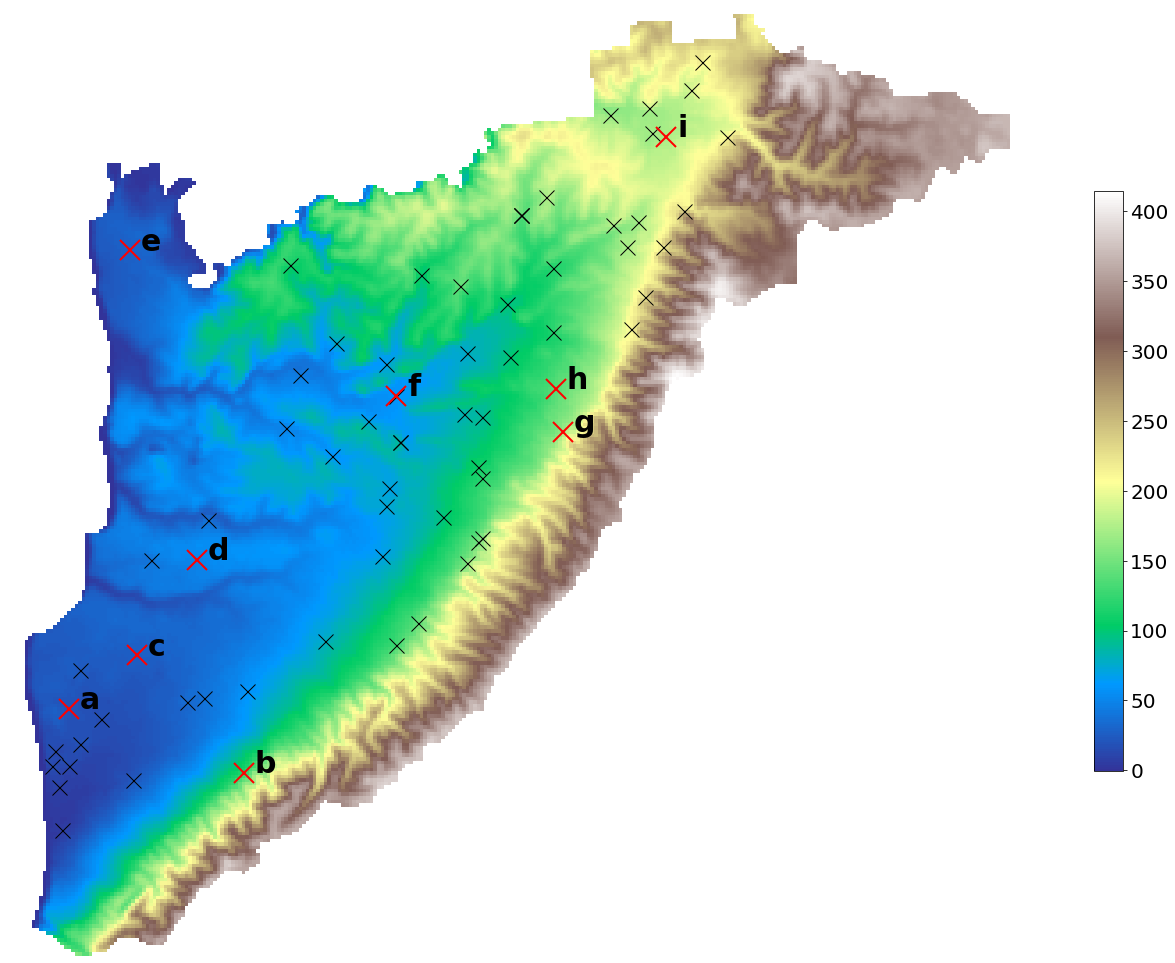

In [123]:
plt.figure(figsize=(20,20))

ax2=plt.subplot(111, frameon=False)


image_hidden = ax2.imshow(dem_ar_crop[0,:,:], cmap=dem_cmap)
cb = plt.colorbar(image_hidden, fraction=0.026, pad=0.06)

for t in cb.ax.get_yticklabels():
     t.set_fontsize(20)
        
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

#for i in range(len(well_ixs)):
 #   ax2.plot(well_ixs[i][1],well_ixs[i][0], "kx", markersize=10, label='_nolegend_')

for ix in df_head_at_wells_from_rstr_noletters.index:
    x = df_head_at_wells_from_rstr_noletters.loc[ix, 'well_ix'][1]
    y = df_head_at_wells_from_rstr_noletters.loc[ix, 'well_ix'][0]
    ax2.plot(x,y,"kx", markersize=15,label='_nolegend_')
    
    
# For legend
#ax2.plot(well_ixs[i][1],well_ixs[i][0], "kx", alpha=0.1, markersize=10, label="Hydraulic head measurement")    

for i in range(len(wells_letter_ixs)):
    ax2.plot(wells_letter_ixs[i][1], wells_letter_ixs[i][0], "rx", markersize=20, 
             markeredgewidth=2,label="Estimation point")    


#plt.legend(frameon=False, fontsize=18, loc=4)
offset_am = 3
for ix in wells_letter_df.index:
    x = df_head_at_wells_from_rstr.loc[ix, 'well_ix'][1]
    y = df_head_at_wells_from_rstr.loc[ix, 'well_ix'][0]
    ltr = wells_letter_df.loc[ix, 'rswl']
    plt.text(x+offset_am,y,ltr, c='k', fontsize=30, fontweight="bold")

plt.savefig(os.path.join(figuredirectory, "dem_letters"), dpi=300)

# BELOW - where I am up to

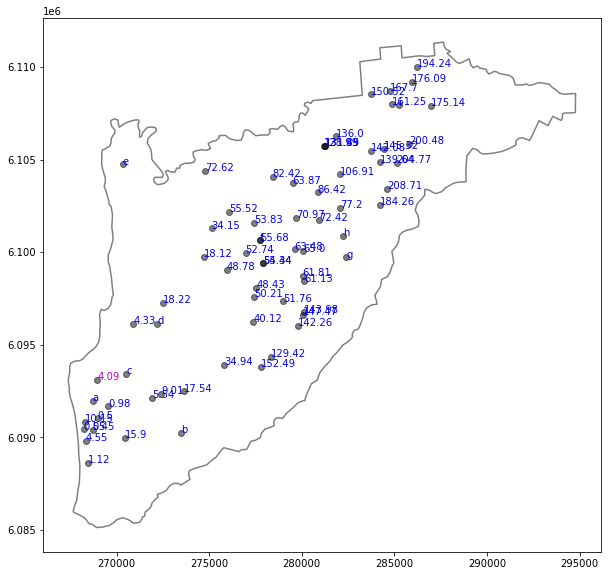

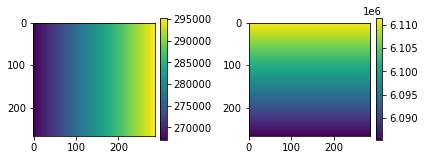

In [207]:

plt.figure(figsize=(10,10))
plt.plot(e_wells, n_wells, "ko", alpha=0.5)

for i in range(len(rswl_wells)):
    if i == 0:
        plt.text(e_wells[i], n_wells[i], "%s"%rswl_wells[i], c="m")
        
    else:
        plt.text(e_wells[i], n_wells[i], "%s"%rswl_wells[i], c="b")
    
ax1=plt.gca()
study_area_shp_utm.exterior.plot(ax=ax1, color="0.5", label="Study area")

plt.figure()
plt.subplot(1,2,1)
plt.imshow(xs)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.imshow(ys)
plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()

# BELOW THIS - WHERE I AM UP TO

## Plot the location of the letterered wells


On a background of DEM

## See if I can pull in the UTM raster

In [115]:
utm

<Projected CRS: EPSG:32754>
Name: WGS 84 / UTM zone 54S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 138°E and 144°E, southern hemisphere between 80°S and equator, onshore and offshore. Australia. Indonesia. Papua New Guinea.
- bounds: (138.0, -80.0, 144.0, 0.0)
Coordinate Operation:
- name: UTM zone 54S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [114]:
print(type(dem_rstr))

print("DEM raster crs is: %s" % dem_rstr.crs)
print("DEM raster shape: %s" % (dem_rstr.shape,))
print("DEM raster type: %s" % (type(dem_rstr)))

print("DEM raster mode is: %s" %dem_rstr.mode)
print("Is the DEM raster closed?: %s" %dem_rstr.closed)

<class 'rasterio.io.DatasetReader'>
DEM raster crs is: EPSG:32754
DEM raster shape: (1013, 1202)
DEM raster type: <class 'rasterio.io.DatasetReader'>
DEM raster mode is: r
Is the DEM raster closed?: False


In [172]:
with rasterio.open(dem_rstr_path) as grd:
    dem_ar = grd.read()[0,:,:]
    dem_meta = grd.profile   
    dem_bounds = grd.bounds
    dem_res = grd.res
    
mask = np.zeros_like(dem_ar)
nrows,ncols = np.shape(mask)



In [169]:
print(dem_bounds)

BoundingBox(left=266930.5015377677, bottom=6085112.138345794, right=295289.9695764501, top=6111495.336834743)


### Plot the DEM

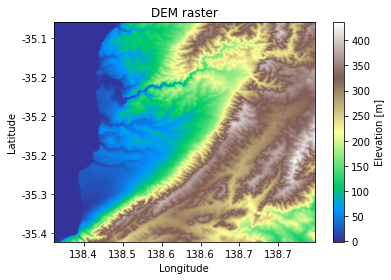

## Plot the letters on top of the DEM

## Looking at variability in estimate at wells

In [45]:
df_head_at_wells_from_rstr["rswl"] = df_head_at_wells_from_rstr["rswl"].apply(pd.to_numeric, errors='raise')

In [46]:
df_head_at_wells_from_rstr.tail(2)


,DHNO,rswl,well_ix,ref_001,ref_002,ref_003,ref_004,ref_005,ref_008,ref_009,...,ref_024,ref_025,ref_026,ref_029,ref_030,ref_031,ref_032,ref_033,ref_034,ref_036
DHNO,,,,,,,,,,,,,,,,,,,,,
new3,new3,NaN,"(155, 53)",9.999249,11.607593,12.187277,9.432354,10.877201,10.535300,10.058204,...,11.857807,11.117329,11.414048,12.432697,10.618283,10.055367,12.041704,12.226385,10.606509,10.835374
new4,new4,NaN,"(68, 34)",4.326117,-1.677065,7.789410,9.318331,0.805374,3.097975,44.012310,...,-2.589106,9.135742,3.086692,40.730713,38.841431,30.087482,19.697723,2.666463,2.990274,4.443453


### Testing if the indexes/values look right

I think they look ok

C:\Users\mar886\AppData\Local\Temp/ipykernel_2340/3888664435.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


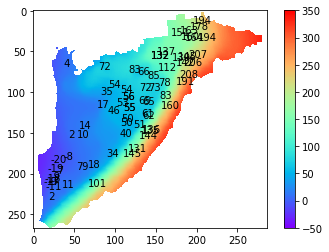

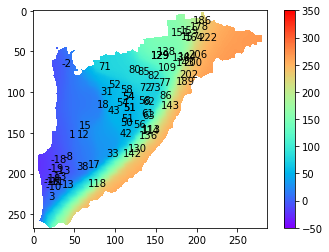

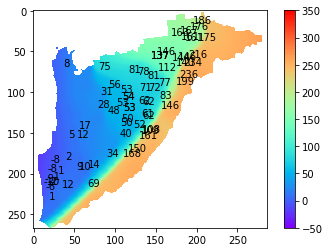

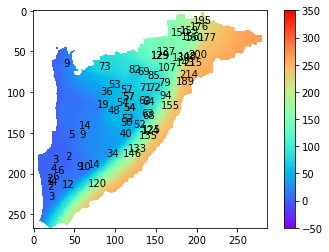

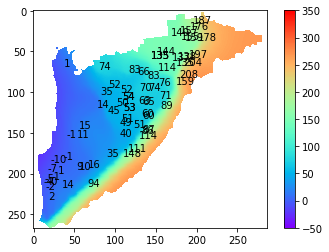

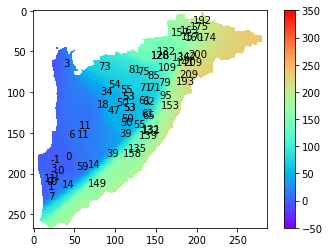

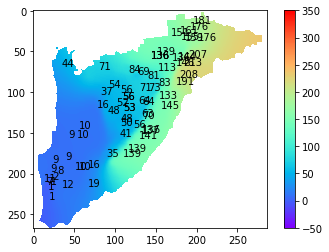

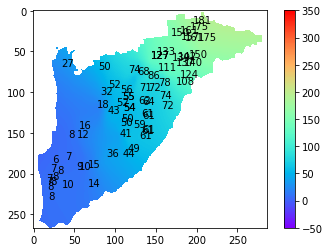

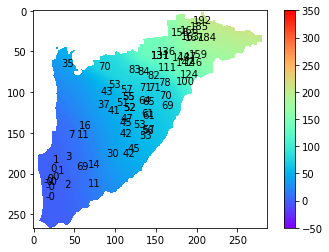

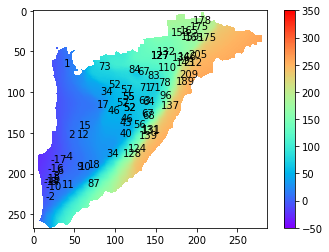

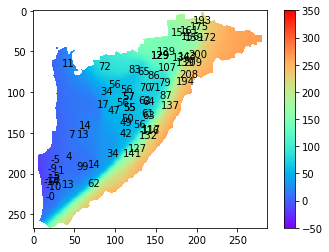

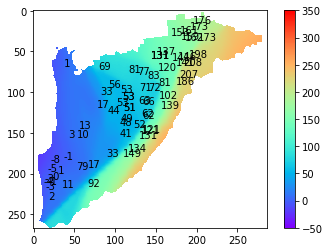

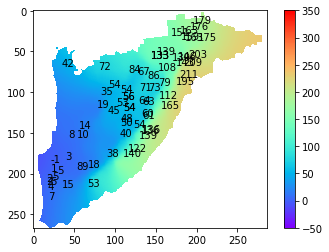

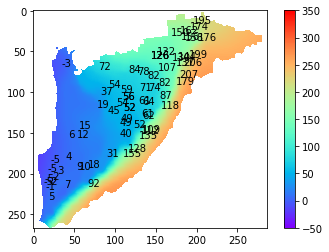

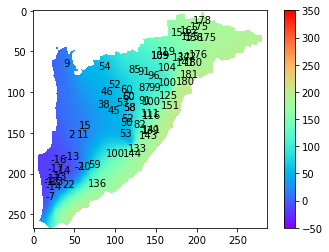

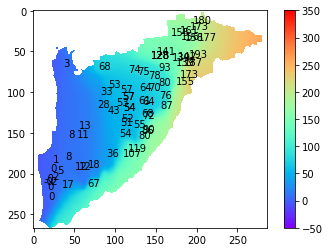

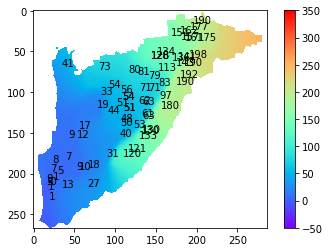

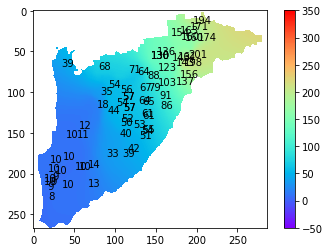

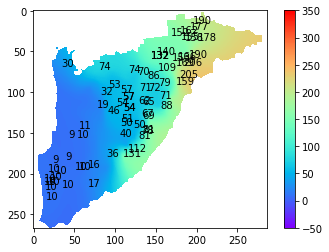

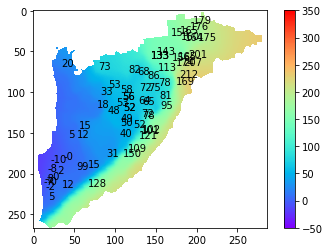

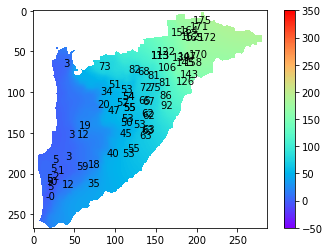

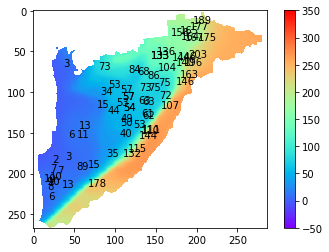

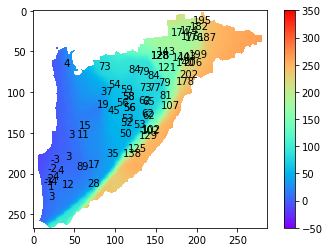

In [81]:
df_head_at_wells_from_rstr
rstr_i = 0    

for rstr_i in range(len(estimated_arrays)):
    plt.figure()
    plt.imshow(wt_crops_ars[rstr_i], cmap=wt_cmap, vmin=-50, vmax=350) #
    plt.colorbar()

    for i in range(len(well_ixs)):
        ix = well_ixs[i]
        raster_head_val = estimated_arrays[rstr_i][ix[0], ix[1]]
        plt.text(ix[1], ix[0], "%2.0f" %raster_head_val)

In [82]:
df_head_at_wells_from_rstr.head()

,DHNO,rswl,well_ix,ref_001,ref_002,ref_003,ref_004,ref_005,ref_008,ref_009,...,ref_024,ref_025,ref_026,ref_029,ref_030,ref_031,ref_032,ref_033,ref_034,ref_036
DHNO,,,,,,,,,,,,,,,,,,,,,
26558,26558,4.09,"(186, 20)",-20.203262,-18.057812,-7.563098,2.955072,-9.637142,-1.262213,8.995111,...,-5.263478,-16.259899,1.112820,7.571603,10.148191,9.396303,-9.671530,4.646134,1.646033,-3.302031
26565,26565,4.33,"(155, 40)",1.742489,0.965118,4.902679,5.247573,-0.501065,5.967878,8.872720,...,6.314466,2.270485,7.920587,8.944342,9.866714,8.544065,5.303022,3.035818,6.485984,2.730164
26585,26585,18.22,"(144, 56)",14.311897,15.319687,17.065609,13.750219,15.092476,10.868571,10.327415,...,15.383167,14.800434,13.020567,16.676876,11.715546,10.691982,15.104589,18.527225,13.312990,15.187326
27050,27050,5.54,"(195, 50)",6.538256,2.622898,9.101677,8.543658,8.600751,5.021411,9.544954,...,9.427304,-1.686317,11.836983,8.609028,9.500857,9.704159,8.577205,5.394264,8.095343,8.371509
27063,27063,15.90,"(217, 35)",10.516420,12.784949,11.679647,12.474450,13.786293,13.844901,11.932571,...,7.214375,21.974171,16.659534,13.306984,10.436093,9.768251,11.934229,11.541338,12.745776,11.766327


First I need to change data type to numeric (maybe do this earlier?)

In [83]:
df_head_at_wells_from_rstr[rstr_names].apply(pd.to_numeric)

,ref_001,ref_002,ref_003,ref_004,ref_005,ref_008,ref_009,ref_012b,ref_012,ref_014,...,ref_024,ref_025,ref_026,ref_029,ref_030,ref_031,ref_032,ref_033,ref_034,ref_036
DHNO,,,,,,,,,,,,,,,,,,,,,
26558,-20.203262,-18.057812,-7.563098,2.955072,-9.637142,-1.262213,8.995111,6.163566,0.554819,-16.706440,...,-5.263478,-16.259899,1.112820,7.571603,10.148191,9.396303,-9.671530,4.646134,1.646033,-3.302031
26565,1.742489,0.965118,4.902679,5.247573,-0.501065,5.967878,8.872720,7.718161,6.687495,1.839479,...,6.314466,2.270485,7.920587,8.944342,9.866714,8.544065,5.303022,3.035818,6.485984,2.730164
26585,14.311897,15.319687,17.065609,13.750219,15.092476,10.868571,10.327415,15.748018,16.492119,14.693321,...,15.383167,14.800434,13.020567,16.676876,11.715546,10.691982,15.104589,18.527225,13.312990,15.187326
27050,6.538256,2.622898,9.101677,8.543658,8.600751,5.021411,9.544954,9.419268,6.488711,8.678637,...,9.427304,-1.686317,11.836983,8.609028,9.500857,9.704159,8.577205,5.394264,8.095343,8.371509
27063,10.516420,12.784949,11.679647,12.474450,13.786293,13.844901,11.932571,10.148715,1.578328,11.382176,...,7.214375,21.974171,16.659534,13.306984,10.436093,9.768251,11.934229,11.541338,12.745776,11.766327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200678,132.011780,128.824036,136.926422,129.308899,135.046509,127.574760,135.647949,127.169312,130.932983,126.989960,...,125.748276,108.799210,128.413345,128.026855,130.100235,132.226929,132.508743,112.554146,133.473969,127.607063
new1,-7.708371,-8.037018,2.343328,2.459142,-0.545681,0.018456,8.502505,7.112274,3.114691,-4.315008,...,3.837847,-13.064213,8.277631,6.768766,9.825121,8.729925,-0.178159,3.048712,3.173881,2.611526
new2,159.834564,143.357864,145.505524,155.230057,89.188828,153.021423,144.705414,71.700989,68.616440,137.424591,...,118.454544,150.733521,87.072304,180.091339,86.113464,87.635262,94.990967,92.177689,107.425339,106.873566


In [84]:
mean_values = df_head_at_wells_from_rstr[rstr_names].mean(axis=1)
print(mean_values)

DHNO
26558      -3.006384
26565       5.325863
26585      14.317521
27050       7.662330
27063      12.035811
             ...    
200678    128.827209
new1        1.824900
new2      122.642082
new3       11.141907
new4       14.560490
Length: 71, dtype: float32


In [85]:
df_head_at_wells_from_rstr['mean_wells'] = df_head_at_wells_from_rstr[rstr_names].mean(axis=1)
df_head_at_wells_from_rstr['std_wells'] = df_head_at_wells_from_rstr[rstr_names].std(axis=1)
df_head_at_wells_from_rstr.head()

,DHNO,rswl,well_ix,ref_001,ref_002,ref_003,ref_004,ref_005,ref_008,ref_009,...,ref_026,ref_029,ref_030,ref_031,ref_032,ref_033,ref_034,ref_036,mean_wells,std_wells
DHNO,,,,,,,,,,,,,,,,,,,,,
26558,26558,4.09,"(186, 20)",-20.203262,-18.057812,-7.563098,2.955072,-9.637142,-1.262213,8.995111,...,1.112820,7.571603,10.148191,9.396303,-9.671530,4.646134,1.646033,-3.302031,-3.006384,9.176537
26565,26565,4.33,"(155, 40)",1.742489,0.965118,4.902679,5.247573,-0.501065,5.967878,8.872720,...,7.920587,8.944342,9.866714,8.544065,5.303022,3.035818,6.485984,2.730164,5.325863,2.917795
26585,26585,18.22,"(144, 56)",14.311897,15.319687,17.065609,13.750219,15.092476,10.868571,10.327415,...,13.020567,16.676876,11.715546,10.691982,15.104589,18.527225,13.312990,15.187326,14.317521,2.087791
27050,27050,5.54,"(195, 50)",6.538256,2.622898,9.101677,8.543658,8.600751,5.021411,9.544954,...,11.836983,8.609028,9.500857,9.704159,8.577205,5.394264,8.095343,8.371509,7.662330,2.785769
27063,27063,15.90,"(217, 35)",10.516420,12.784949,11.679647,12.474450,13.786293,13.844901,11.932571,...,16.659534,13.306984,10.436093,9.768251,11.934229,11.541338,12.745776,11.766327,12.035811,3.609472


### Plot just based on well number

Something weird happening with rswl - BECAUSE THEY ARE STRINGS!

In [53]:
#df_head_at_wells_from_rstr.loc[wellname, "rswl"]

Text(0, 0.5, 'Head (m)')

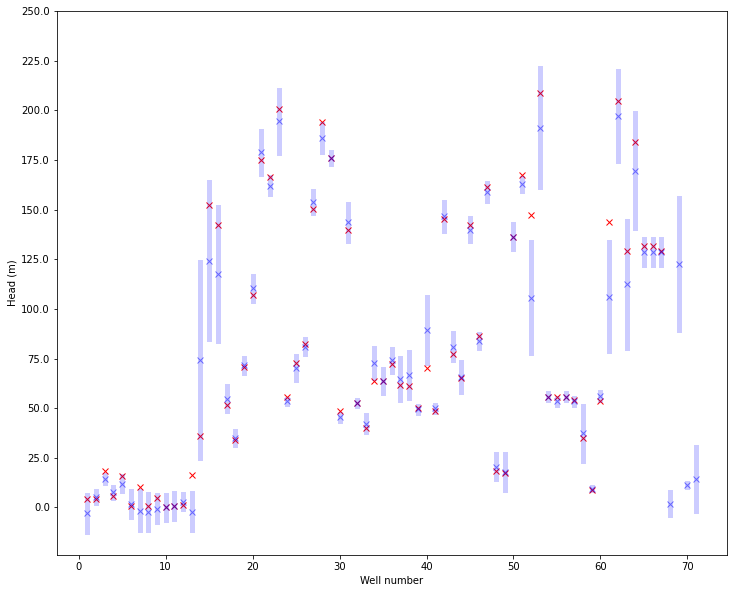

In [86]:
fig = plt.figure(figsize = (12,10))
ax = plt.gca()
rswl_val = []

xval = 1

for idx in df_head_at_wells_from_rstr.index:

    x = []
    y = []
    wellname = idx

    for i in range(len(rstr_names)):
        x.append(xval)
        y.append(df_head_at_wells_from_rstr.loc[wellname, rstr_names[i]])

    std_upper = df_head_at_wells_from_rstr.loc[wellname, "mean_wells"] +  df_head_at_wells_from_rstr.loc[wellname, "std_wells"]
    std_lower = df_head_at_wells_from_rstr.loc[wellname, "mean_wells"] -  df_head_at_wells_from_rstr.loc[wellname, "std_wells"]
    
    rswl_val.append(df_head_at_wells_from_rstr.loc[wellname, "rswl"])
    ax.plot(xval, df_head_at_wells_from_rstr.loc[wellname, "rswl"], "rx", label="Measured (m)")
    ax.plot(xval, df_head_at_wells_from_rstr.loc[wellname, "mean_wells"], "bx", alpha=0.5, label="Mean (m)")
    ax.plot([xval, xval], [std_upper,std_lower], "b-", lw=5, alpha=0.2)

    # Plotting all the data
    #ax.plot(x,y, "kx")
    
    xval += 1
    
#plt.legend()
ticks = np.linspace(0, 250, 11) 
plt.yticks(ticks=ticks, labels=ticks)
plt.xlabel("Well number")
plt.ylabel("Head (m)")

### Plot based on measured value

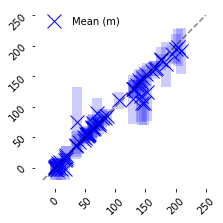

In [88]:
fig = plt.figure(figsize = (3.2,3.2))
ax = plt.gca()

for idx in df_head_at_wells_from_rstr.index:

    x = []
    y = []
    wellname = idx

    meas = df_head_at_wells_from_rstr.loc[wellname, "rswl"]
    #print("Measured head is: %s" %meas)

    
    
    for i in range(len(rstr_names)):
        x.append(meas)
        y.append(df_head_at_wells_from_rstr.loc[wellname, rstr_names[i]])

    std_upper = df_head_at_wells_from_rstr.loc[wellname, "mean_wells"] +  df_head_at_wells_from_rstr.loc[wellname, "std_wells"]
    std_lower = df_head_at_wells_from_rstr.loc[wellname, "mean_wells"] -  df_head_at_wells_from_rstr.loc[wellname, "std_wells"]

    ax.plot(meas, df_head_at_wells_from_rstr.loc[wellname, "mean_wells"], "bx", label="_nolegend_", markersize=14)
    ax.plot([meas, meas], [std_upper,std_lower], "b-", lw=10, alpha=0.2)

    # Plotting all the data
    #ax.plot(x,y, "kx")
    
    xval += 1
    
#plt.legend()
ticks = np.linspace(0, 250, 6, dtype=int) 
plt.yticks(ticks=ticks, labels=ticks, fontsize=10,  rotation=45)
plt.xticks(ticks=ticks, labels=ticks, fontsize=10,  rotation=45)


#plt.xlabel("Measured head (mAHD)", fontsize=18)
#plt.ylabel("Estimated head from raster (mAHD)", fontsize=18)



# Plot 1-1 line ---
plt.plot(np.linspace(-20,250,100), np.linspace(-20,250,100), 'k--', alpha=0.5)


# Plot legend
ax.plot(meas, df_head_at_wells_from_rstr.loc[wellname, "mean_wells"], "bx", label="Mean (m)", markersize=14)
#ax.plot([-10, -10], [20,50], "b-", lw=10, alpha=0.2, label = "+/- Std")

plt.legend(frameon=False, fontsize=10, loc=2)

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

plt.tight_layout()

plt.savefig(os.path.join(figuredirectory, "rmse_allwells"), dpi=300)

## Calculate rmse

In [89]:
# First add empty column to add the values

df_head_at_wells_from_rstr["rmse"] = ""

In [90]:
import math
rmse_dict = {}
rmse = []

rstr_i

# for rstr_i in range(len(rstr_names))

for idx in df_head_at_wells_from_rstr.index:

    meas = df_head_at_wells_from_rstr.loc[idx, "rswl"]
   #print("Meas: %s"%meas)
    
    resids = []
    for rstr_i in range(len(rstr_names)):
        est = df_head_at_wells_from_rstr.loc[idx, rstr_names[rstr_i]]
        resids.append((meas-est)**2)
    resids = np.array(resids)
    
    
    rmse = math.sqrt(np.sum(resids)/len(resids))
    
    df_head_at_wells_from_rstr.loc[idx, 'rmse'] = rmse

# value of rmse across all rasters and all wells?

rmse_all = df_head_at_wells_from_rstr.sum()

rmse_total = rmse_all['rmse']/len(df_head_at_wells_from_rstr.index)

print(rmse_total)

10.857428469993412


## Plot standard deviation as a function of the well head

First change rswl to numeric

<AxesSubplot:xlabel='rswl', ylabel='mean_wells'>

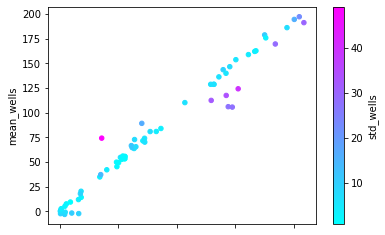

In [91]:
df_head_at_wells_from_rstr.plot.scatter(x = "rswl", y = "mean_wells", 
                                        c = "std_wells", colormap="cool")

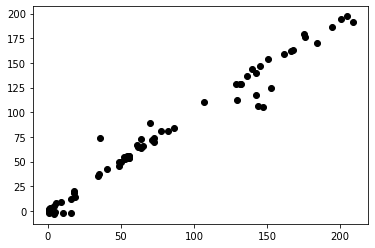

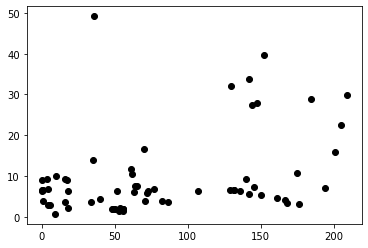

In [92]:
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(df_head_at_wells_from_rstr['rswl'], df_head_at_wells_from_rstr['mean_wells'], 'ko')

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(df_head_at_wells_from_rstr['rswl'], df_head_at_wells_from_rstr['std_wells'], 'ko')

## Pull in the estimated values at well locations

From the survey: https://csiroau.sharepoint.com/:x:/r/sites/PostdocSarahMarshall/Shared%20Documents/General/Willunga/manual_wt_survey.xlsx?d=wedfe971df99a444592a5e00444ba769e&csf=1&web=1&e=NyRcKW 

Save results: C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\survey_results

** Need to save as CSV-UTF-8 data type


** I need to go through the results for the estimates and convert them to numbers, where they are a range, use the mean of that range
    

In [93]:
survey_path = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\survey_results', "manual_wt_survey.csv")

In [94]:
survey_results = pd.read_csv(survey_path)

In [62]:
#survey_results.columns
#for col in range(len(survey_results.columns)):
 #   print(col)
  #  print(survey_results.columns[col])

22
Please predict the water level for point a on the map (Grid reference A8)
23
Please predict the water level for pointÊbÊon the map (Grid reference C8)
24
Please predict the water level for pointÊcÊon the map (Grid reference B7)
25
Please predict the water level for pointÊdÊon the map (Grid reference C6)
26
Please predict the water level for pointÊeÊon the map (Grid reference E5)
27
Please predict the water level for pointÊfÊon the map (Grid reference F5)
28
Please predict the water level for pointÊgÊon the map (Grid reference G5)
29
Please predict the water level for pointÊhÊon the map (Grid reference G5)
30
Please predict the water level for pointÊiÊon the map (Grid reference H2)
31
Please predict the water level for pointÊjÊon the map (Grid reference I2)

In [95]:
wt_q_idxs = [22,23,24,25,26,27,28,29,30]
wt_q_letters = ['a','b','c','d','e','f','g','h','i']

wt_q_idxs_dict = {'a': 22, 'b': 23, 'c': 24, 'd': 25, 'e': 26, 'f': 27, 'g': 28, 'h': 29, 'i': 30, 'j': 31}

In [96]:
wt_qs_df = survey_results[survey_results.columns[wt_q_idxs]]

In [97]:
# Replace nans
wt_qs_df = wt_qs_df.replace(-9999,np.nan)

print(wt_qs_df.columns)

Index(['Please predict the water level for point a on the map (Grid reference A8)',
       'Please predict the water level for pointÊbÊon the map (Grid reference C8)',
       'Please predict the water level for pointÊcÊon the map (Grid reference B7)',
       'Please predict the water level for pointÊdÊon the map (Grid reference C6)',
       'Please predict the water level for pointÊeÊon the map (Grid reference E5)',
       'Please predict the water level for pointÊfÊon the map (Grid reference F5)',
       'Please predict the water level for pointÊgÊon the map (Grid reference G5)',
       'Please predict the water level for pointÊhÊon the map (Grid reference G5)',
       'Please predict the water level for pointÊiÊon the map (Grid reference H2)'],
      dtype='object')


In [98]:
well_names_guessed = ["27125", "39875", "new1", "new3", "new4", "180822", "new2", "46232", "42108"]

wt_qs_df.columns = well_names_guessed
print(wt_qs_df)

    27125  39875  new1  new3  new4  180822   new2  46232  42108
0     5.0  100.0     7     3  54.0      63  152.0   99.0    172
1     1.0  100.0     7    12  55.0      58  150.0   90.0    170
2     3.0   50.0     6    12   8.0      54  125.0   85.0    165
3     7.0  100.0     5    10  10.0      55  150.0  110.0    165
4     1.5    5.0     4    10   4.0      54  147.0   77.0    162
5     2.0  150.0     4    12   6.0      56  150.0  100.0    162
6     5.0   65.0     5    10   4.0      54  150.0  130.0    164
7     3.0   90.0     7    11   5.0      57  135.0  110.0    164
8     5.0   30.0     5    10  10.0      55   80.0   80.0    170
9     1.0   20.0     5    15   1.0      56   75.0   73.0    160
10    5.0   50.0     5    10   2.0      56  175.0  125.0    163
11   20.0  200.0    10    50   0.0      30  200.0  200.0    225
12    1.0   10.0     5    12  30.0      55   68.0   71.0    166
13    1.0   30.0     5    13   5.0      55   92.0   88.0    164
14    1.0   22.0     5    12   1.0      

### Plot - compare estimated values to rasters

In [100]:
wt_qs_df[well_names_guessed[0]].mean()
wt_qs_df[well_names_guessed[0]].std()


18.866282349382182

In [101]:
wt_qs_df.loc[0,"27125"]

5.0

In [102]:
wells_df_2_gdf.index

Index(['26558', '26565', '26585', '27050', '27063', '27107', '27112', '27113',
       '27117', '27118', '27119', '27121', '27125', '39875', '39932', '40002',
       '40495', '40740', '40794', '42029', '42104', '42108', '42117', '42173',
       '42190', '42279', '43439', '43470', '43490', '44644', '45105', '45276',
       '45418', '45475', '46069', '46129', '46196', '46212', '46229', '46232',
       '46299', '46552', '46725', '46726', '46734', '46736', '131933',
       '142342', '156132', '166221', '166767', '166769', '177637', '179079',
       '179080', '180822', '180838', '182233', '186362', '195701', '196280',
       '196571', '196608', '196609', '200676', '200677', '200678', 'new1',
       'new2', 'new3', 'new4'],
      dtype='object', name='DHNO')

27125
39875
new1
new3
new4
180822
new2
46232
42108


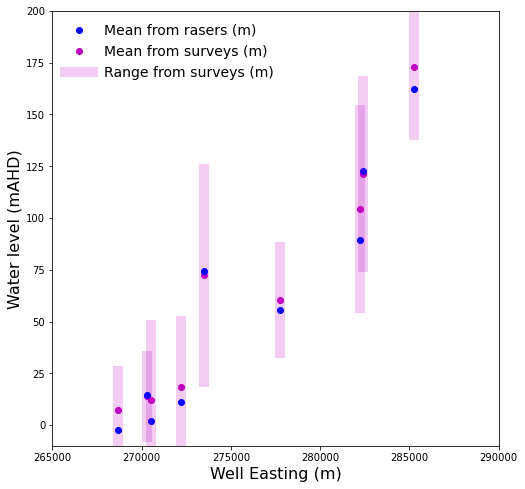

In [103]:
fig = plt.figure(figsize = (8,8))
ax = plt.gca()
offset=0

xval = 1

for idx in well_names_guessed:

    x = []
    y = []
    wellname = idx
    print(idx)
    
    for i in range(len(wt_qs_df)):
        x.append(xval)
        y.append(wt_qs_df.loc[i,idx])
        
    #xval = df_head_at_wells_from_rstr.loc[wellname, 'well_ix'][0]    
    xval = wells_df_2_gdf.loc[wellname, 'mga_easting']
    #plt.plot(x,y,"kx")
    
    # Survey results
    std_upper = wt_qs_df[idx].mean() +  wt_qs_df[idx].std()
    std_lower = wt_qs_df[idx].mean() -  wt_qs_df[idx].std()
    ax.plot([xval-1, xval-1], [std_upper,std_lower], "m-", lw=10, alpha=0.2,label='_nolegend_')

    ax.plot(xval-offset, wt_qs_df[idx].mean(), "mo", alpha=1.0, label='_nolegend_')

    # Raster results
    std_upper = df_head_at_wells_from_rstr.loc[wellname, "mean_wells"] +  df_head_at_wells_from_rstr.loc[wellname, "std_wells"]
    std_lower = df_head_at_wells_from_rstr.loc[wellname, "mean_wells"] -  df_head_at_wells_from_rstr.loc[wellname, "std_wells"]
    #ax.plot([xval+offset, xval+offset], [std_upper,std_lower], "b-", lw=10, alpha=0.2)    
    
    ax.plot(xval+offset, df_head_at_wells_from_rstr.loc[wellname, "mean_wells"], "bo", alpha=1.0, label='_nolegend_')

    
    xval += 1
    
ax.plot(-20, -20, "bo", alpha=1.0, label="Mean from rasers (m)")
ax.plot(-20, -20, "mo", alpha=1.0, label="Mean from surveys (m)")

#ax.plot([-20,-21], [-20,-21], "b-", lw=10, alpha=0.2, label="Range from rasers (m)")
ax.plot([-20,-21], [-20,-21], "m-", lw=10, alpha=0.2, label="Range from surveys (m)")

plt.legend(fontsize=14, frameon=False)

plt.xlim([265000,250000+40000])
plt.ylim([-10,200])

plt.xlabel("Well Easting (m)", fontsize=16)
plt.ylabel("Water level (mAHD)", fontsize=16)

plt.savefig(os.path.join(figuredirectory,"survey_wells"), dpi=300)

## Calculate RMSE for survey results


In [104]:
df_head_at_wells_from_rstr

,DHNO,rswl,well_ix,ref_001,ref_002,ref_003,ref_004,ref_005,ref_008,ref_009,...,ref_029,ref_030,ref_031,ref_032,ref_033,ref_034,ref_036,mean_wells,std_wells,rmse
DHNO,,,,,,,,,,,,,,,,,,,,,
26558,26558,4.09,"(186, 20)",-20.203262,-18.057812,-7.563098,2.955072,-9.637142,-1.262213,8.995111,...,7.571603,10.148191,9.396303,-9.671530,4.646134,1.646033,-3.302031,-3.006384,9.176537,11.441426
26565,26565,4.33,"(155, 40)",1.742489,0.965118,4.902679,5.247573,-0.501065,5.967878,8.872720,...,8.944342,9.866714,8.544065,5.303022,3.035818,6.485984,2.730164,5.325863,2.917795,3.022435
26585,26585,18.22,"(144, 56)",14.311897,15.319687,17.065609,13.750219,15.092476,10.868571,10.327415,...,16.676876,11.715546,10.691982,15.104589,18.527225,13.312990,15.187326,14.317521,2.087791,4.404395
27050,27050,5.54,"(195, 50)",6.538256,2.622898,9.101677,8.543658,8.600751,5.021411,9.544954,...,8.609028,9.500857,9.704159,8.577205,5.394264,8.095343,8.371509,7.662330,2.785769,3.453604
27063,27063,15.90,"(217, 35)",10.516420,12.784949,11.679647,12.474450,13.786293,13.844901,11.932571,...,13.306984,10.436093,9.768251,11.934229,11.541338,12.745776,11.766327,12.035811,3.609472,5.233908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200678,200678,128.99,"(58, 144)",132.011780,128.824036,136.926422,129.308899,135.046509,127.574760,135.647949,...,128.026855,130.100235,132.226929,132.508743,112.554146,133.473969,127.607063,128.827209,6.482436,6.342038
new1,new1,NaN,"(182, 36)",-7.708371,-8.037018,2.343328,2.459142,-0.545681,0.018456,8.502505,...,6.768766,9.825121,8.729925,-0.178159,3.048712,3.173881,2.611526,1.824900,5.796780,NaN
new2,new2,NaN,"(119, 156)",159.834564,143.357864,145.505524,155.230057,89.188828,153.021423,144.705414,...,180.091339,86.113464,87.635262,94.990967,92.177689,107.425339,106.873566,122.642082,33.049404,NaN


In [105]:
ix = wells_we_know[0]

meas = df_head_at_wells_from_rstr.loc[ix, 'rswl']

diff = []
for i in wt_qs_df.index:
    est = wt_qs_df.loc[i, ix]
    #print("est:%s" %(est))
    #print("est:%s" %type(est))
    diff_power_2 = ((meas-est)**2)
    #print(diff_power_2)
    diff.append(diff_power_2)
    
diff = np.array(diff)
sum = np.nansum(diff)
#print(sum)
div_sum = sum/np.count_nonzero(~np.isnan(diff))
#print(div_sum)
rmse = math.sqrt(div_sum)
print(rmse)

NameError: name 'wells_we_know' is not defined

In [106]:
wt_qs_df.columns

wells_we_know = ['27125', '39875', '180822',  '46232', '42108']

rmse_surveys = []

for ix in wells_we_know:
    meas = df_head_at_wells_from_rstr.loc[ix, 'rswl']
    print('meas:%s'%meas)
    print("ix:%s"%ix)
    
    diff = []
    for i in wt_qs_df.index:
        est = wt_qs_df.loc[i, ix]
        #print("est:%s" %(est))
        #print("est:%s" %type(est))
        diff_power_2 = ((meas-est)**2)
        #print(diff_power_2)
        diff.append(diff_power_2)
        
    diff = np.array(diff)
    sum = np.nansum(diff)
    #print(sum)
    div_sum = sum/np.count_nonzero(~np.isnan(diff))
    #print(div_sum)
    rmse = math.sqrt(div_sum)
    print(rmse)
    rmse_surveys.append(rmse)
print(rmse_surveys)

rmse_surveys = np.array(rmse_surveys)

avr_survey_rmse= np.mean(rmse_surveys)

print("Average rmse from survey is: %s" %avr_survey_rmse)

meas:16.11
ix:27125
20.449129928063314
meas:35.77
ix:39875
62.38561699376152
meas:55.58
ix:180822
25.57708807669002
meas:70.07
ix:46232
58.03645479511292
meas:166.65
ix:42108
32.443081457881874
[20.449129928063314, 62.38561699376152, 25.57708807669002, 58.03645479511292, 32.443081457881874]
Average rmse from survey is: 39.778274250301926


##  Same plot as above but for survey results


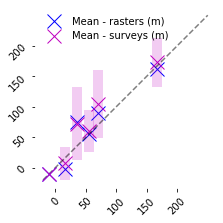

In [112]:
fig = plt.figure(figsize = (3.2,3.2))
ax = plt.gca()

for idx in wells_we_know:

    x = []
    y = []
    wellname = idx

    meas = df_head_at_wells_from_rstr.loc[wellname, "rswl"]
    #print("Measured head is: %s" %meas)

    
    
    for i in range(len(rstr_names)):
        x.append(meas)
        y.append(df_head_at_wells_from_rstr.loc[wellname, rstr_names[i]])

    std_upper = wt_qs_df[idx].mean() +  wt_qs_df[idx].std()
    std_lower = wt_qs_df[idx].mean() -  wt_qs_df[idx].std()

    ax.plot(meas, df_head_at_wells_from_rstr.loc[wellname, "mean_wells"], "bx", label='_nolegend_', markersize=14)
    ax.plot([meas, meas], [std_upper,std_lower], "m-", lw=10, alpha=0.2)
    
    ax.plot(meas, wt_qs_df[idx].mean(), "mx", markersize=14, alpha=1.0, label='_nolegend_')


    # Plotting all the data
    #ax.plot(x,y, "kx")
    
    xval += 1
    
#plt.legend()
ticks = np.linspace(0, 200, 5, dtype=int) 
plt.yticks(ticks=ticks, labels=ticks, fontsize=10,  rotation=45)
plt.xticks(ticks=ticks, labels=ticks, fontsize=10,  rotation=45)
#plt.xlabel("Measured head (mAHD)", fontsize=16)
#plt.ylabel("Estimated head from survey (mAHD)", fontsize=16)

plt.plot(np.linspace(-20,250,100), np.linspace(-20,250,100), 'k--', alpha=0.5)

ax.plot(-10, -10, "bx", label="Mean - rasters (m)", markersize=14)
ax.plot(-10, -10, "mx", label="Mean - surveys (m)", markersize=14)

#ax.plot([-10, -10], [20,50], "m-", lw=10, alpha=0.2, label = "+/- Std")

plt.legend(frameon=False, fontsize=10, loc=2)

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

plt.tight_layout()
plt.savefig(os.path.join(figuredirectory,"rmse_surveyprediction"), dpi=300)


In [ ]:
#DELETE
fig = plt.figure(figsize = (3.2,3.2))
ax = plt.gca()

for idx in df_head_at_wells_from_rstr.index:

    x = []
    y = []
    wellname = idx

    meas = df_head_at_wells_from_rstr.loc[wellname, "rswl"]
    #print("Measured head is: %s" %meas)

    
    
    for i in range(len(rstr_names)):
        x.append(meas)
        y.append(df_head_at_wells_from_rstr.loc[wellname, rstr_names[i]])

    std_upper = df_head_at_wells_from_rstr.loc[wellname, "mean_wells"] +  df_head_at_wells_from_rstr.loc[wellname, "std_wells"]
    std_lower = df_head_at_wells_from_rstr.loc[wellname, "mean_wells"] -  df_head_at_wells_from_rstr.loc[wellname, "std_wells"]

    ax.plot(meas, df_head_at_wells_from_rstr.loc[wellname, "mean_wells"], "bx", label="_nolegend_", markersize=14)
    ax.plot([meas, meas], [std_upper,std_lower], "b-", lw=10, alpha=0.2)

    # Plotting all the data
    #ax.plot(x,y, "kx")
    
    xval += 1
    
#plt.legend()
ticks = np.linspace(0, 250, 6, dtype=int) 
plt.yticks(ticks=ticks, labels=ticks, fontsize=12,  rotation=45)
plt.xticks(ticks=ticks, labels=ticks, fontsize=12,  rotation=45)


#plt.xlabel("Measured head (mAHD)", fontsize=18)
#plt.ylabel("Estimated head from raster (mAHD)", fontsize=18)



# Plot 1-1 line ---
plt.plot(np.linspace(-20,250,100), np.linspace(-20,250,100), 'k--', alpha=0.5)


# Plot legend
ax.plot(meas, df_head_at_wells_from_rstr.loc[wellname, "mean_wells"], "bx", label="Mean (m)", markersize=14)
ax.plot([-10, -10], [20,50], "b-", lw=10, alpha=0.2, label = "+/- Std")

plt.legend(frameon=False, fontsize=12, loc=2)

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

plt.tight_layout()

In [ ]:
for i in range(len(residuals)):
    print(type(residuals[i]))
    for ir in range(len(residuals[i])):
        if type(residuals[i][ir]) != 'float64':
            print(type(residuals[i][ir]))
        else:
            pass

In [ ]:
plt.figure()

for idx in wt_qs_df.columns:
    x = df_head_at_wells_from_rstr.loc[idx, "mean_wells"]
    y = wt_qs_df[idx].mean()
    
    plt.plot(x,y,'kx')
    
plt.plot(np.linspace(-20, 200, 20), np.linspace(-20, 200, 20), '--')
plt.xlabel("Head estimated from rasters at wells")
plt.ylabel("Head estimated from eyes at wells")

plt.figure()

for idx in wt_qs_df.columns:
    x = df_head_at_wells_from_rstr.loc[idx, "rswl"]
    y = wt_qs_df[idx].mean()
    
    plt.plot(x,y,'kx')
    
plt.plot(np.linspace(-20, 200, 20), np.linspace(-20, 200, 20), '--')
plt.xlabel("Head measured from dipping at wells")
plt.ylabel("Head estimated from eyes at wells")

plt.figure()

for idx in wt_qs_df.columns:
    x = df_head_at_wells_from_rstr.loc[idx, "rswl"]
    y = df_head_at_wells_from_rstr.loc[idx, "mean_wells"]
    
    plt.plot(x,y,'kx')
    
plt.plot(np.linspace(-20, 200, 20), np.linspace(-20, 200, 20), '--')
plt.xlabel("Head measured from dipping at wells")
plt.ylabel("Head estimated from rasters at wells")

In [ ]:
# Plotting all the data
#ax.plot(x,y, "kx")
    
    
    
#plt.legend()
ticks = np.linspace(0, 250, 11) 
plt.yticks(ticks=ticks, labels=ticks)
plt.xlabel("Well number")
plt.ylabel("Head (m)")